In [6]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.rcParams.update({'font.size': 24}) #make plots more readable
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

import palettable as pal

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

In [7]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis
        
def kthbitset(arr, k):
    boo = []
    for i in range(len(arr)):
        if arr[i] & (1 << (k-1)):
            boo.append('True')
        else:
            boo.append('False')
    return np.asarray(boo)
        

In [8]:
test = np.array([1,2,4,34,647483,5])

kthbitset(test,4)

array(['False', 'False', 'False', 'False', 'True', 'False'], dtype='<U5')

In [10]:
#########################
### Import fits files ###
#########################

#PARSEC Isochrones
'''
isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
Ages used 8 to 10.1 steps 0.15 
Metallicity used -2.6 to 0.1 steps 0.099
'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#LMC r13 data
lmcr13 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits.gz',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

#LMC RGB DR16
dr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits.gz',1)
clnrr13 = np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                   (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))

clndr16 = dr16[clnrr13]

#Diane Feuillet Bayesian Ages
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits.gz', 1)
clnpdfout = pdfout[ np.where((dr16['FE_H']>-9999.0)&(dr16['AK_TARG']>-9999.0)&(dr16['LOGG']>0.0)&
                             (dr16['M_H_ERR']>-90.0)&(dr16['C_FE']>-9999.0)&(dr16['N_FE']>-9999.0))]

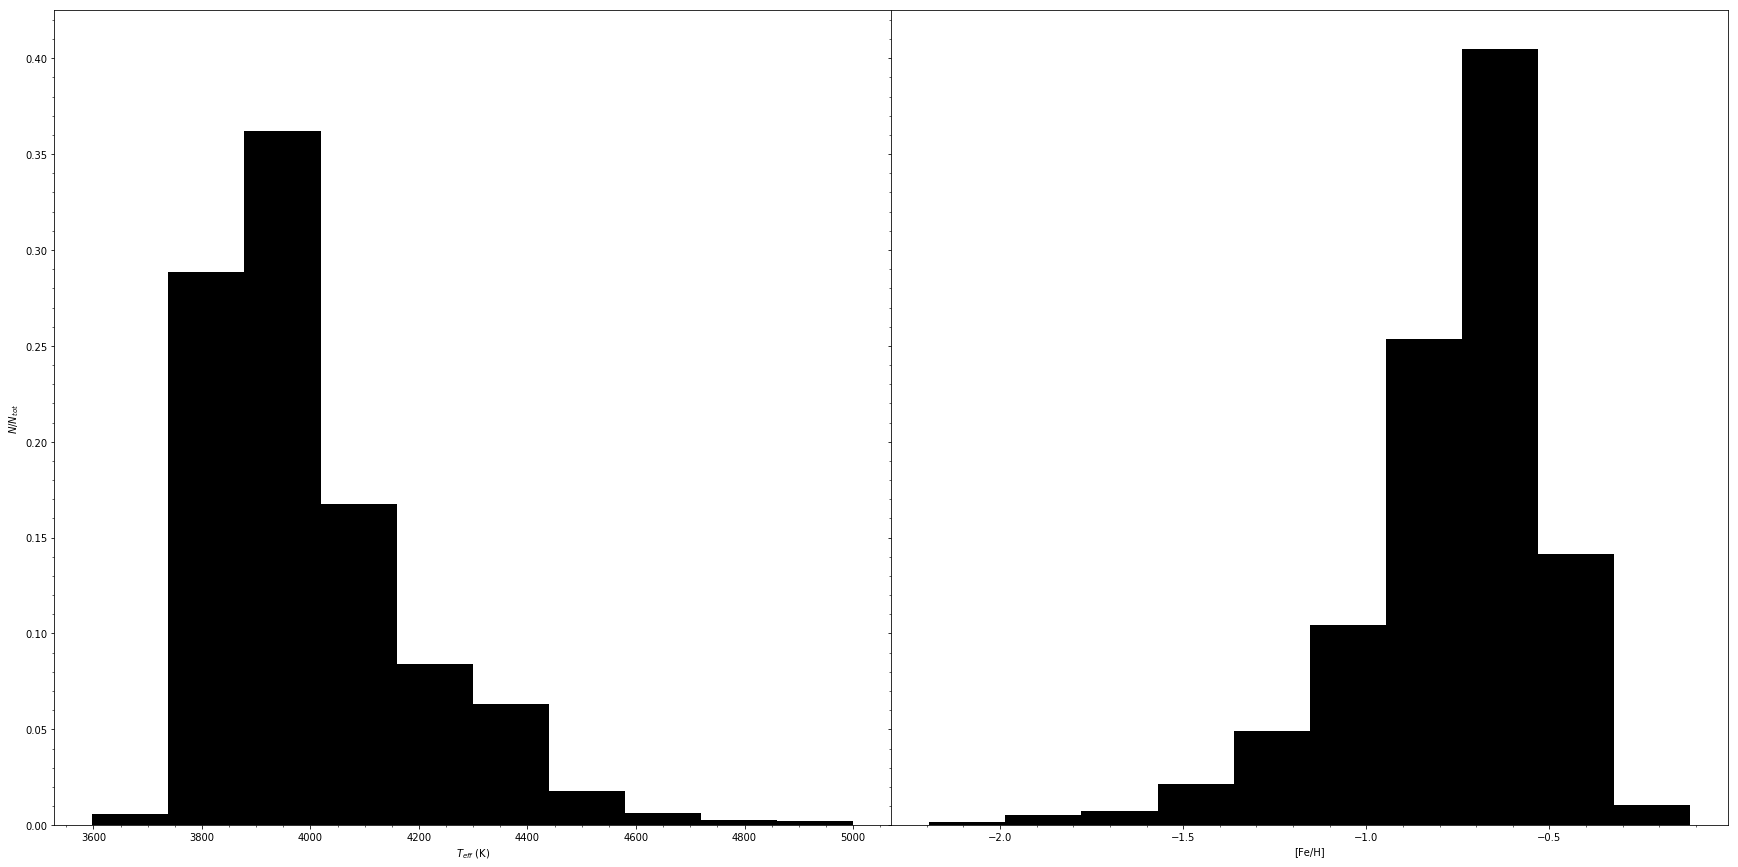

In [11]:
##############################################
### Temperature and Metallicity Histograms ###
##############################################

f, ax = plt.subplots(1,2,sharey=True,facecolor='w',figsize=(30,15))
teffweights = np.ones_like(r13['TEFF'])/float(len(r13['TEFF']))
fehweights = np.ones_like(r13['FE_H'])/float(len(r13['FE_H']))
ax[0].hist(r13['TEFF'],color='k',weights=teffweights)
ax[0].set_xlabel(r'$T_{eff}$ (K)')
ax[0].set_ylabel(r'$N/N_{tot}$')
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].hist(r13['FE_H'],color='k',weights=fehweights)
ax[1].set_xlabel(r'[Fe/H]')
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [12]:
##########################################
### Calculate Gradients and intercepts ###
##########################################

import statsmodels.api as sm

### Circular galactic radius for LMC
radius = np.sqrt((LMCdisk_cart(r13['RA'],r13['DEC'])[0])**2+(LMCdisk_cart(r13['RA'],r13['DEC'])[1])**2)

### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

### A matrix in Ax=b
# A = np.vstack([r13['LMCRAD']*0.875,np.ones(len(r13['LMCRAD']))]).T

elems_slope = []
elems_inter = []

for i in range(len(elems)-5):
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
#     A = np.vstack([radius[cln],np.ones(len(radius[cln]))]).T
#     mi, ci = np.linalg.lstsq(A, r13[elems[i]][cln])[0]
#     elems_slope.append(mi)
#     elems_inter.append(ci)
    
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    pmodl = np.array(radius[cln]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(r13[elems[i]][cln],pmodl).fit()
    elems_slope.append(model.params[1])
    elems_inter.append(model.params[0])
    
# cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
#     pmodl = np.array(galmwrad[selstars][thin][cln]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.RLM(alphstars[thin][elems[i]][cln],pmodl).fit()
    
scelems_slope = []
scelems_inter = []

for i in range(len(elems)-5):
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
#     A = np.vstack([radius[cln]*0.59643876,np.ones(len(radius[cln]))]).T
#     mi, ci = np.linalg.lstsq(A, r13[elems[i]][cln])[0]
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    pmodl = np.array(radius[cln]*0.59643876).T
    pmodl = sm.add_constant(pmodl)
    model = sm.RLM(r13[elems[i]][cln],pmodl).fit()
    
    scelems_slope.append(model.params[1])
    scelems_inter.append(model.params[0])
    
for j in range(len(elems)-5):
    print(elems[j]+' slope: '+str(elems_slope[j])+ ' inter: '+ str(elems_inter[j]))

M_H slope: -0.04960612679627079 inter: -0.5683580363447468
C_FE slope: -0.022616068659300985 inter: -0.27072367264603786
N_FE slope: -0.013758492973373606 inter: 0.1674920395911752
O_FE slope: 0.002502164284188434 inter: 0.023389718102673616
NA_FE slope: 0.004649956956659073 inter: -0.20038507021982682
MG_FE slope: 0.005485980429677274 inter: 0.09005288619067141
AL_FE slope: -0.012409590514919142 inter: -0.31128257928543196
SI_FE slope: 0.005595181068073198 inter: -0.016985922736462086
P_FE slope: 0.03243669133726645 inter: -0.03210373571221403
S_FE slope: 0.013385342656524366 inter: 0.146213936257344
K_FE slope: 0.013519063581569072 inter: -0.03832245013328531
CA_FE slope: -0.001759705502346297 inter: 0.10691402126784252
TI_FE slope: 0.02157226621387457 inter: -0.15559960189644356
TIII_FE slope: 0.05202945337257352 inter: -0.20250747717975123
V_FE slope: -0.010470097198442467 inter: -0.09026935722542746
CR_FE slope: -0.009233853243884337 inter: 0.05821469255176545
MN_FE slope: -0.0275

In [13]:
# np.polyfit(radius,r13['M_H'],1)

# import statsmodels.api as sm 

# test = np.array([radius]).T
# test = sm.add_constant(test)
# test_model = sm.OLS(r13['M_H'],test).fit()
# test_predictions = test_model.predict(test)
# test_residual = test_predictions - r13['M_H']
# test_summary = test_model.summary()
# print(test_summary)
# print(np.asarray(test_model.params))

print(len(np.squeeze(np.where(np.isfinite(radius)))))
print(len(radius))

print(len(np.squeeze(np.where(np.isfinite(r13['DEC'])))))

2427
2427
2427


In [14]:
print(len(np.squeeze(np.where(np.isfinite(LMCdisk_cart(r13['RA'],r13['DEC'])[0])))))
print(len(np.squeeze(np.where(np.isfinite(LMCdisk_cart(r13['RA'],r13['DEC'])[1])))))

2427
2427


In [10]:
###############################
### Add Noise to Abundances ###
###############################

def noisy(abund,abund_err):
    
    '''
    - abund: abundnace to add noise to
    - abund_err: error in abund
    '''

    abundnoise = np.random.normal(0,scale=abund_err)
    abundnew = abund + abundnoise

    return abundnew

In [11]:
########################################
### Calculate Gradient Uncertainties ###
########################################

elems_m_devs = []
elems_b_devs = []

Adevs = []
elems_values = []
elems_errors = []
for i in range(len(elems)-5):
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    Adevs.append(np.vstack([radius[cln],np.ones(len(radius[cln]))]).T)
    elems_values.append(r13[elems[i]][cln])
    elems_errors.append(r13[elems[i]+str('_ERR')][cln])

# slopes = []
noisy_values = []
m_devs = []
b_devs = []
for j in range(len(elems)-5):
    slopes = []
    inters = []
    for k in range(1000):
        mi, bi = np.linalg.lstsq(Adevs[j], noisy(elems_values[j],elems_errors[j]))[0]
        slopes.append(mi)
        inters.append(bi)
    m_devs.append(mad(slopes))
    b_devs.append(mad(inters))
    
###Scaled to scale length of 1.68 kpc
    
scelems_m_devs = []
scelems_b_devs = []

Adevs = []
scelems_values = []
scelems_errors = []
for i in range(len(elems)-5):
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    Adevs.append(np.vstack([radius[cln]*0.59643876,np.ones(len(radius[cln]))]).T)
    scelems_values.append(r13[elems[i]][cln])
    scelems_errors.append(r13[elems[i]+str('_ERR')][cln])

# slopes = []
scnoisy_values = []
scm_devs = []
scb_devs = []
for j in range(len(elems)-5):
    scslopes = []
    scinters = []
    for k in range(1000):
        mi, bi = np.linalg.lstsq(Adevs[j], noisy(scelems_values[j],scelems_errors[j]))[0]
        scslopes.append(mi)
        scinters.append(bi)
    scm_devs.append(mad(scslopes))
    scb_devs.append(mad(scinters))

In [12]:
##############################################
### Summary Print Out of Error Calculation ###
##############################################

elem_where = dict(zip(elems,range(len(elems))))
print(elem_where)
print('=== Slope ===')
print(elems_slope)
print('=== Slope Error ===')
print(m_devs)
print('=== Inter ===')
print(elems_inter)
print('=== Inter Error ===')
print(b_devs)

{'M_H': 0, 'C_FE': 1, 'N_FE': 2, 'O_FE': 3, 'NA_FE': 4, 'MG_FE': 5, 'AL_FE': 6, 'SI_FE': 7, 'P_FE': 8, 'S_FE': 9, 'K_FE': 10, 'CA_FE': 11, 'TI_FE': 12, 'TIII_FE': 13, 'V_FE': 14, 'CR_FE': 15, 'MN_FE': 16, 'FE_H': 17, 'CO_FE': 18, 'NI_FE': 19, 'CU_FE': 20, 'GE_FE': 21, 'RB_FE': 22, 'CE_FE': 23, 'ND_FE': 24, 'YB_FE': 25}
=== Slope ===
[-0.05396111627193583, -0.02233470818728746, -0.017212299709551373, 0.0036831609327483464, 0.009644870445772289, 0.005266465640782564, -0.01163272801900784, 0.006283828511951511, 0.03915435230784594, 0.010096973015000446, 0.012446794176835654, -0.0019218784447850071, 0.030329166706364114, 0.03899935992606274, -0.012872292608119333, -0.013567866367483705, -0.027538805520065913, -0.0506518760205578, -0.007591632204068341, -0.0002515549725892065, 0.051239419676698025]
=== Slope Error ===
[0.00017168139201284918, 0.00019714191713235234, 0.0003163481202431099, 0.0002070175553664567, 0.0010148217420401697, 0.0002544131398040119, 0.0004169941028599137, 0.000200783

In [69]:
elem_where

{'M_H': 0,
 'C_FE': 1,
 'N_FE': 2,
 'O_FE': 3,
 'NA_FE': 4,
 'MG_FE': 5,
 'AL_FE': 6,
 'SI_FE': 7,
 'P_FE': 8,
 'S_FE': 9,
 'K_FE': 10,
 'CA_FE': 11,
 'TI_FE': 12,
 'TIII_FE': 13,
 'V_FE': 14,
 'CR_FE': 15,
 'MN_FE': 16,
 'FE_H': 17,
 'CO_FE': 18,
 'NI_FE': 19,
 'CU_FE': 20,
 'GE_FE': 21,
 'RB_FE': 22,
 'CE_FE': 23,
 'ND_FE': 24,
 'YB_FE': 25}

Fe/H: 17
O/Fe: 3
Mg/Fe: 5
Si/Fe: 7
Ca/Fe: 11
Na/Fe: 4
Al/Fe: 6
Cr/Fe: 15
Co/Fe: 18
Ni/Fe: 19

In [13]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [14]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMC(r13['RA'],r13['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(r13['K'],stardist)-r13['AK_TARG']
parage = parsec_age(np.log10(r13['TEFF']),corabsK,sal(r13['M_H'],metscorr),r13['LOGG'])
parage = np.squeeze(parage)

In [15]:
len(r13)

2427

In [16]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [17]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(r13)):
    lgT = np.log10(r13['TEFF'][i])
    lgTERR = 0.434*(np.log(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
    ks = corabsK[i]
    ksERR = r13['K_ERR'][i]
    mh = r13['M_H'][i]
    mhERR = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfeERR = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfeERR = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    fehERR = r13['FE_H_ERR'][i]
    lgg = r13['LOGG'][i]
    lggERR = r13['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

In [18]:
# print(elems)

In [19]:
1/0.59643876

1.6766180655328304

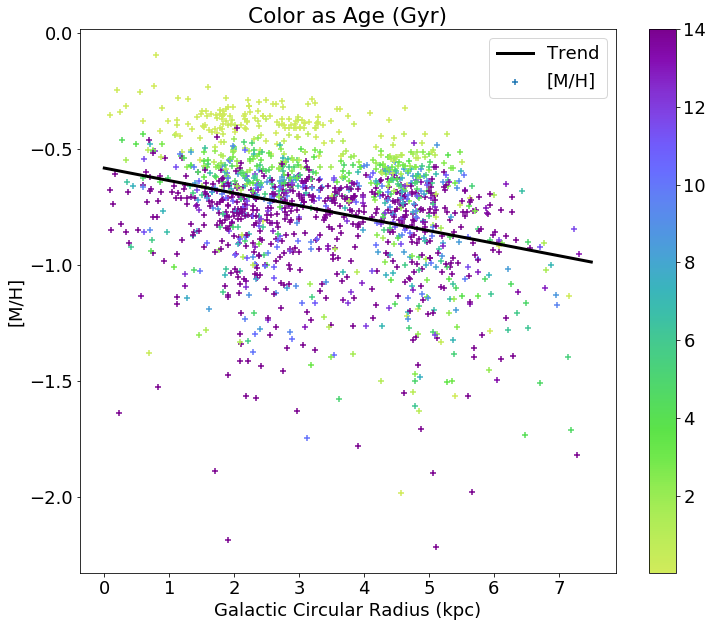

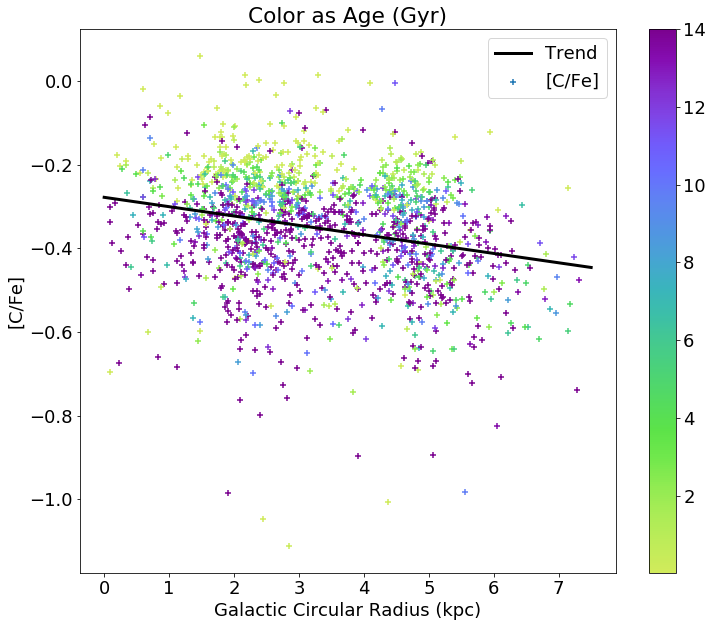

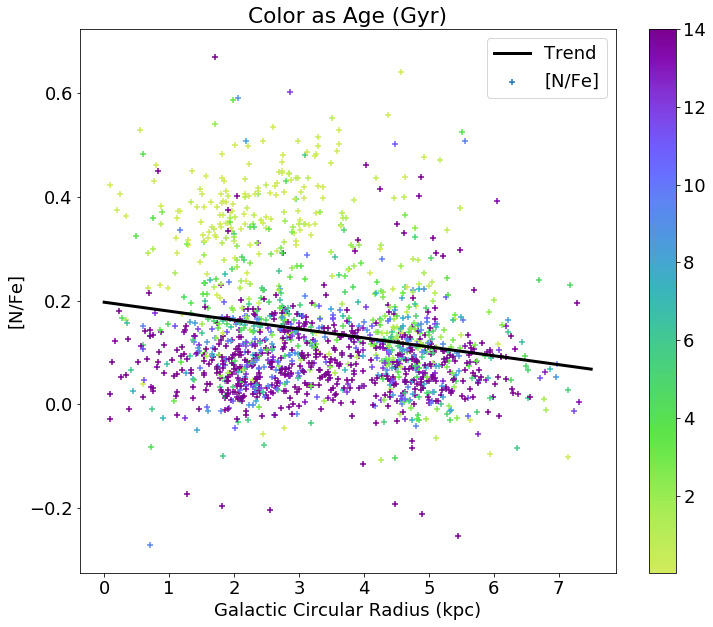

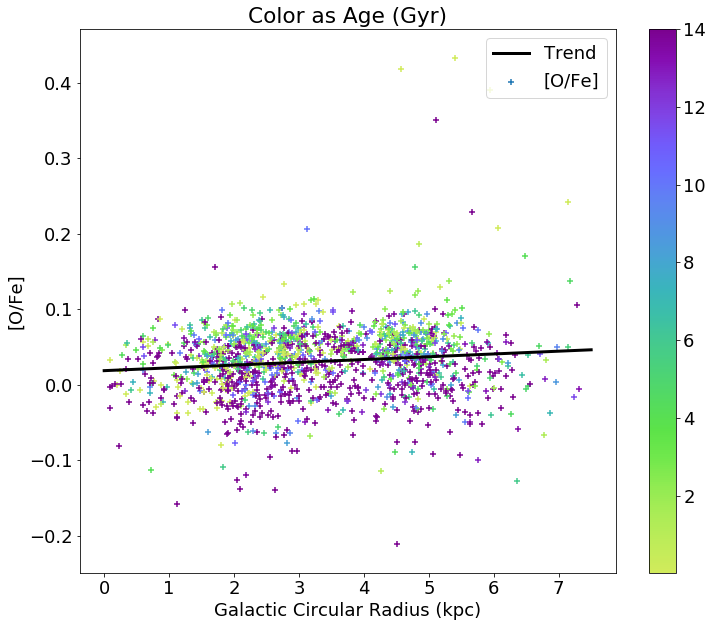

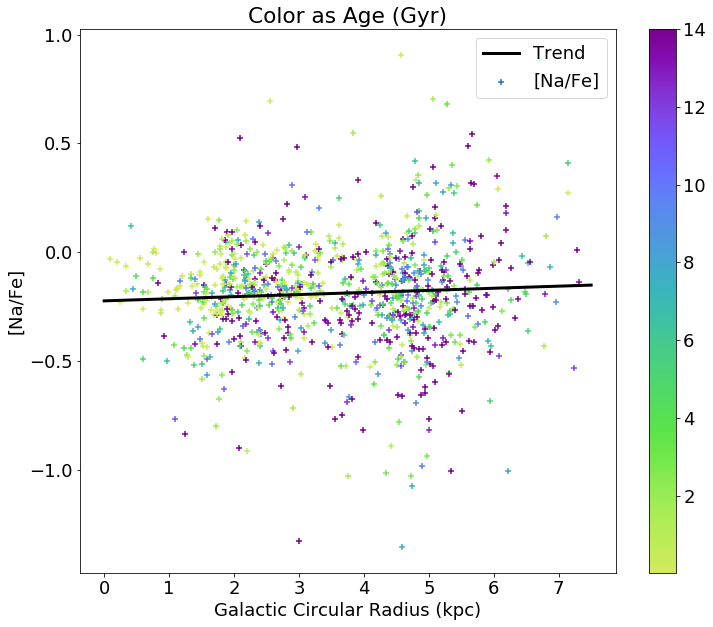

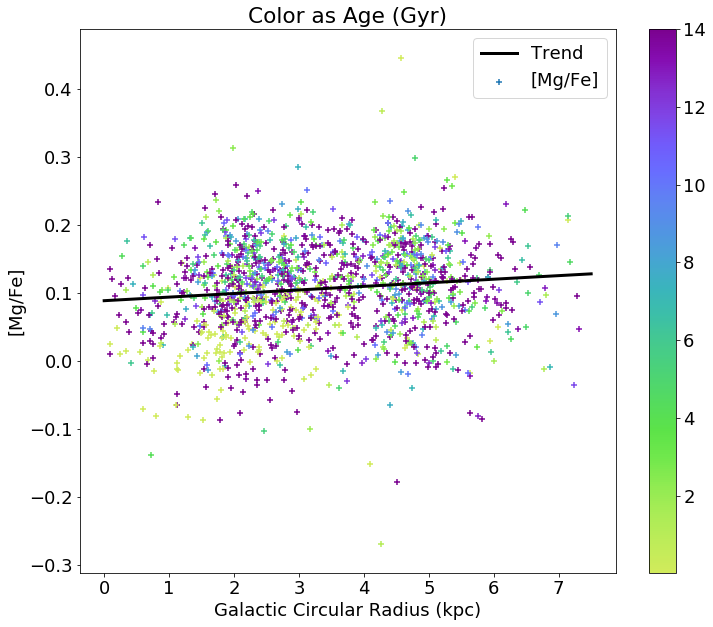

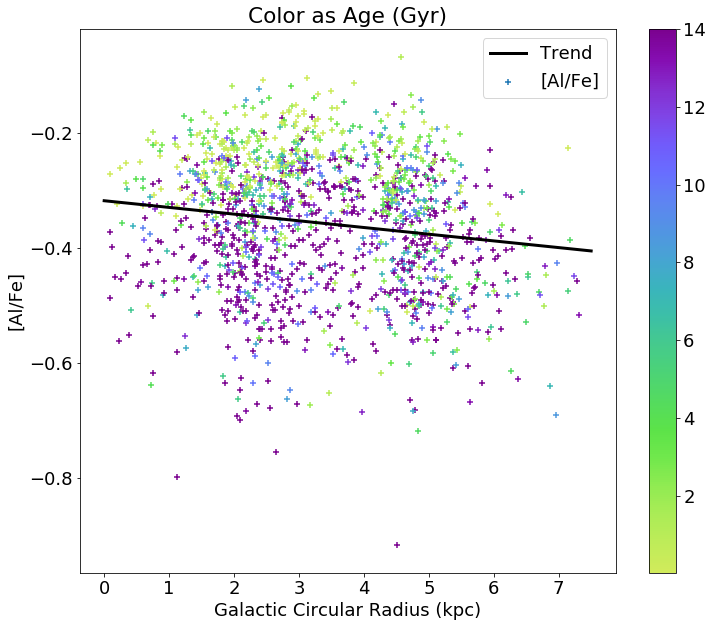

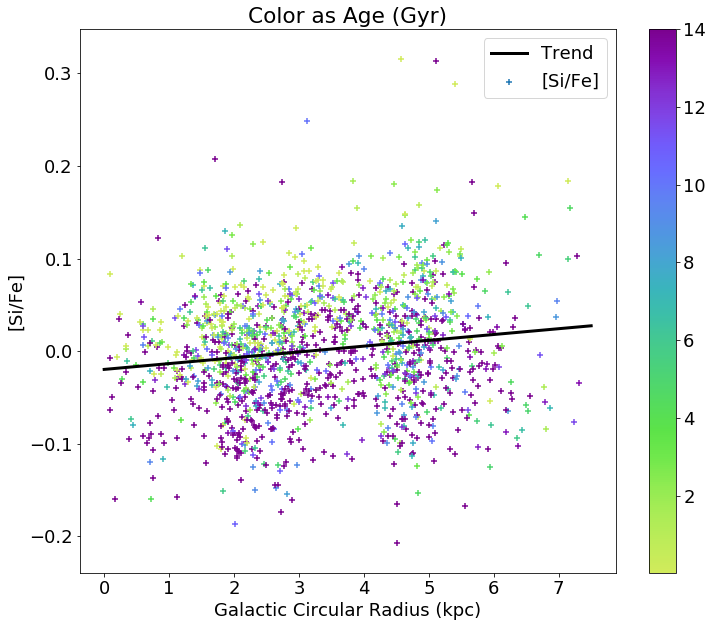

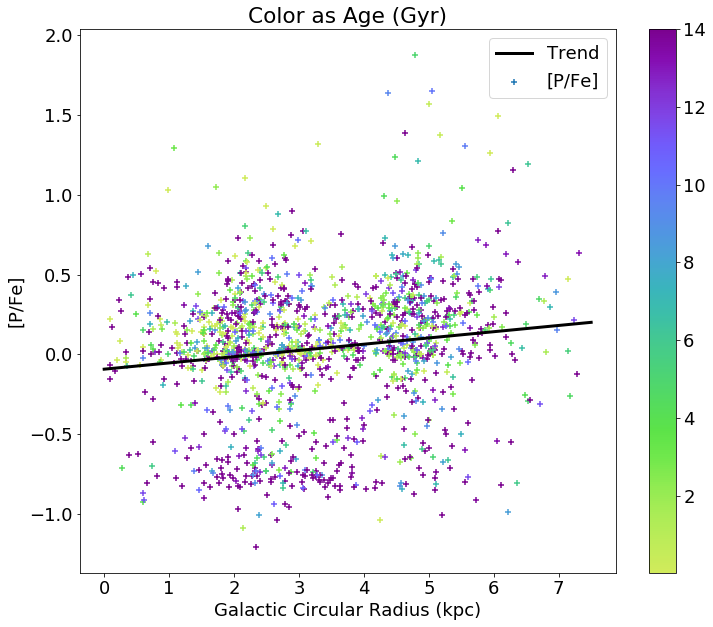

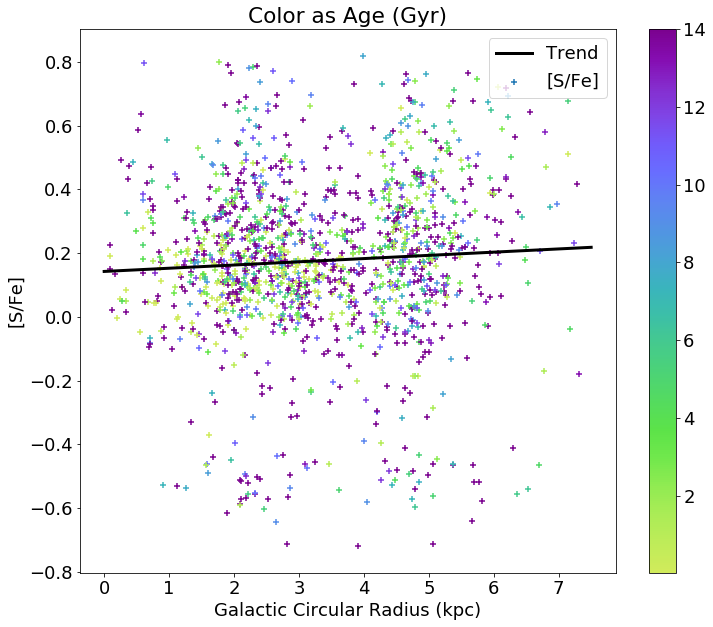

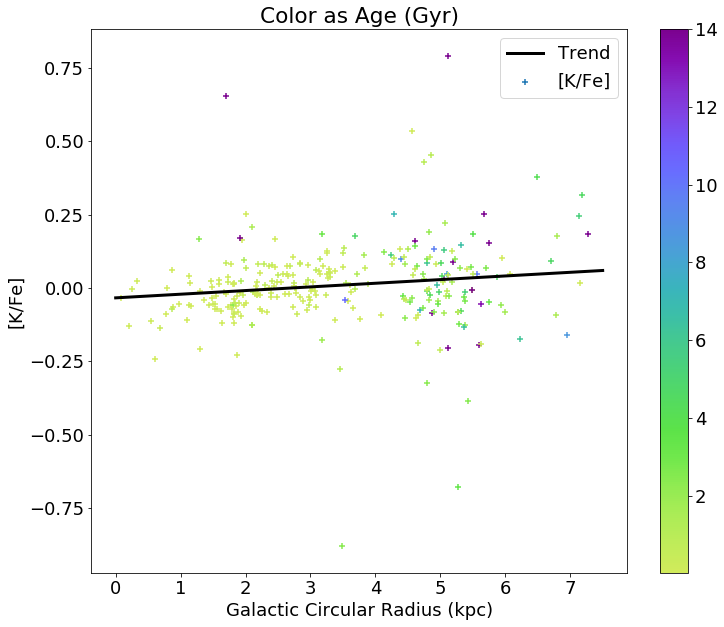

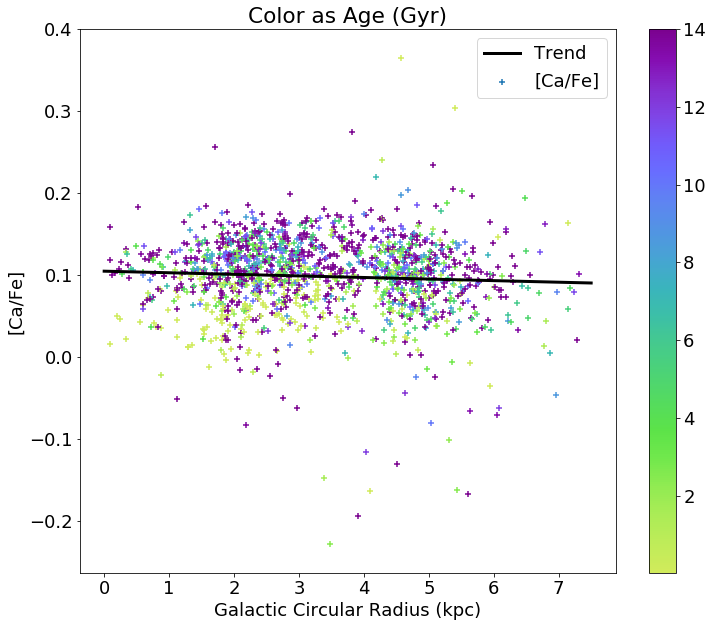

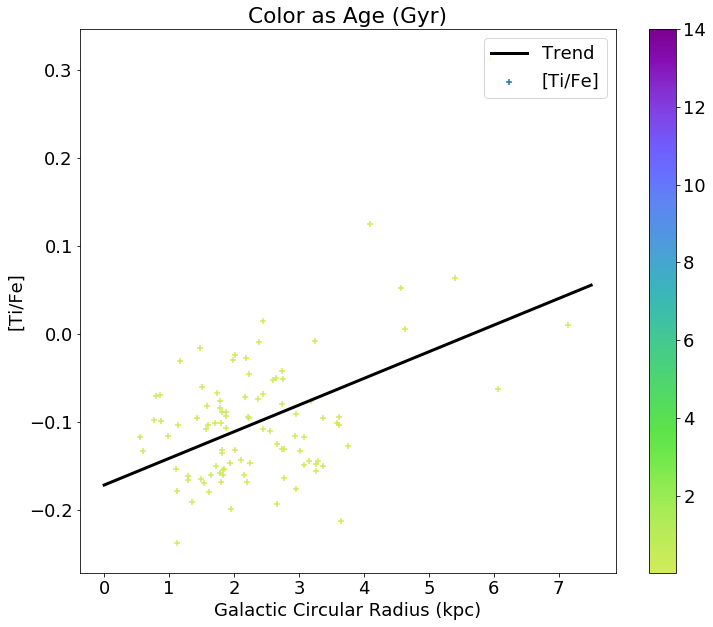

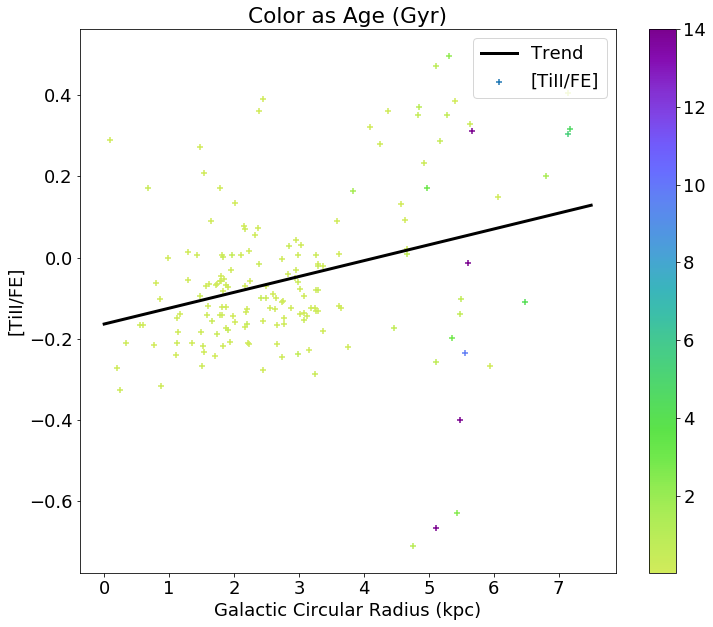

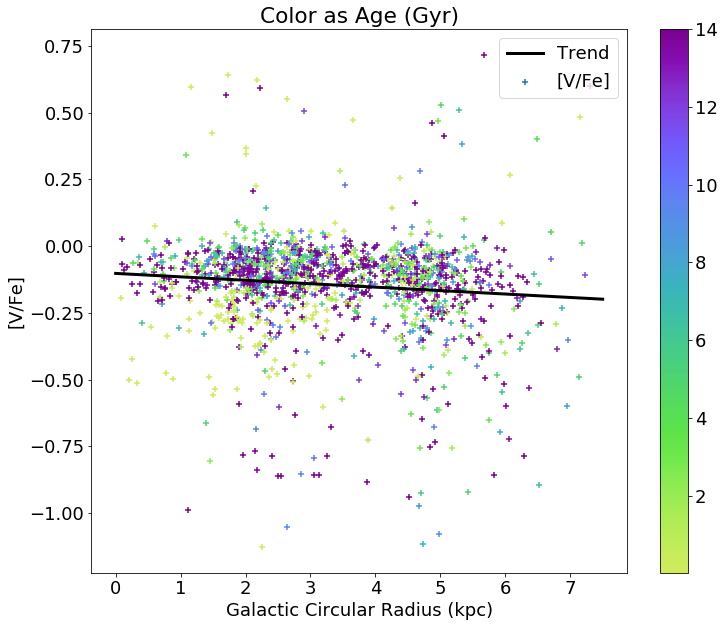

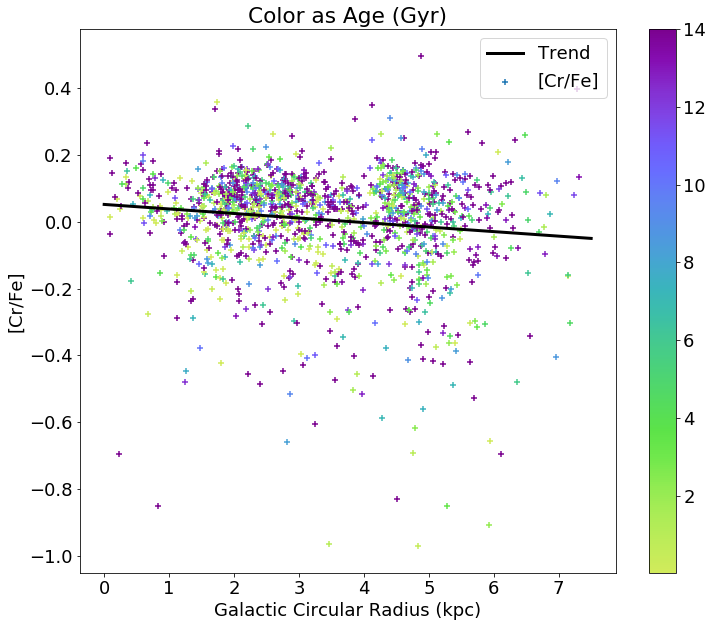

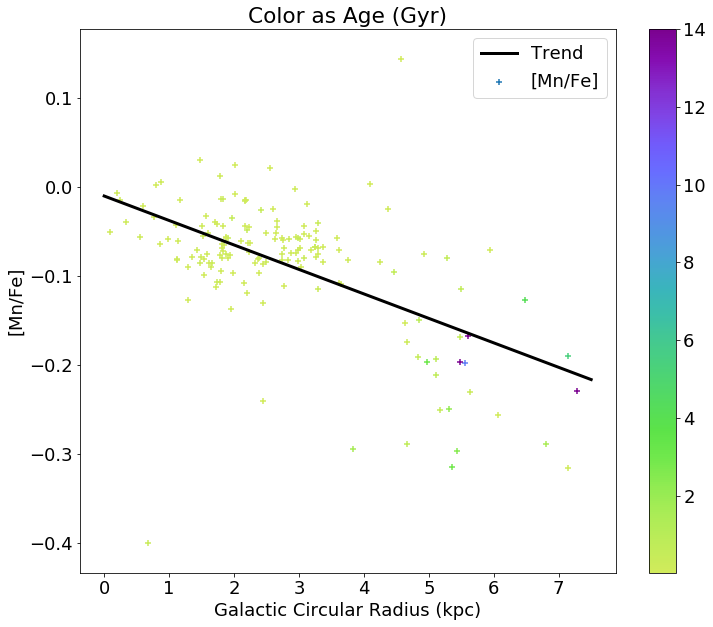

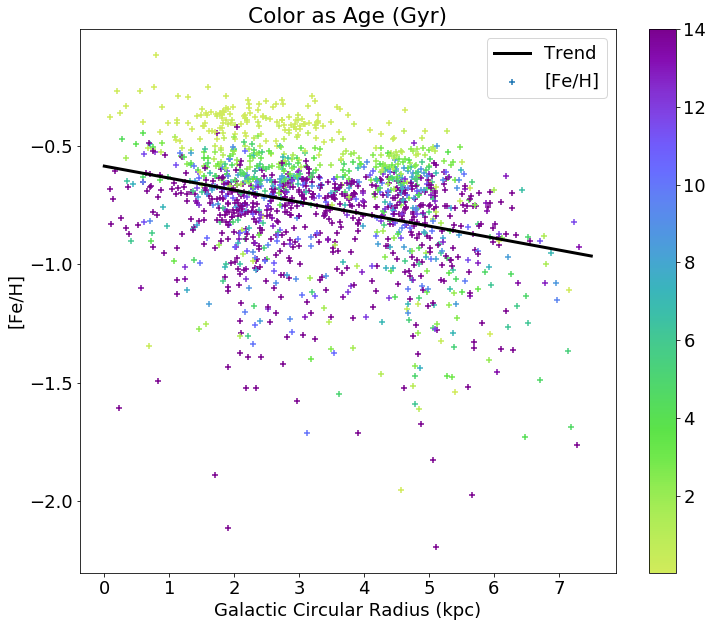

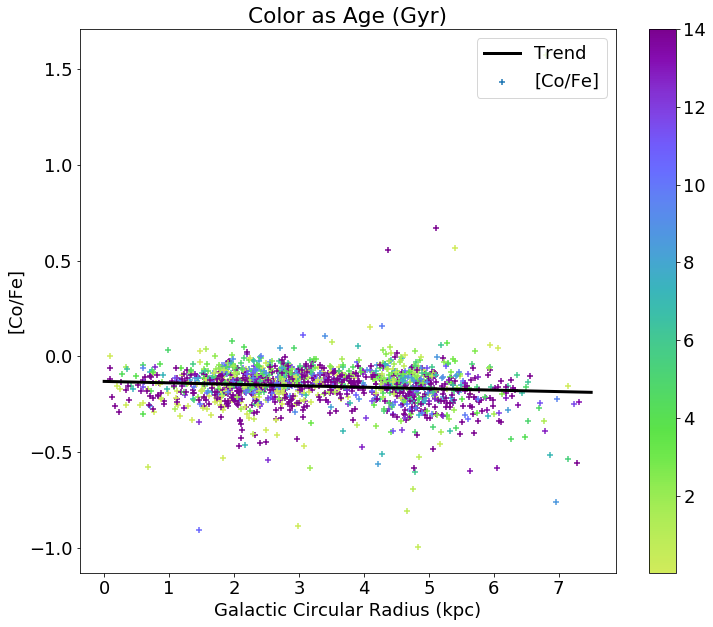

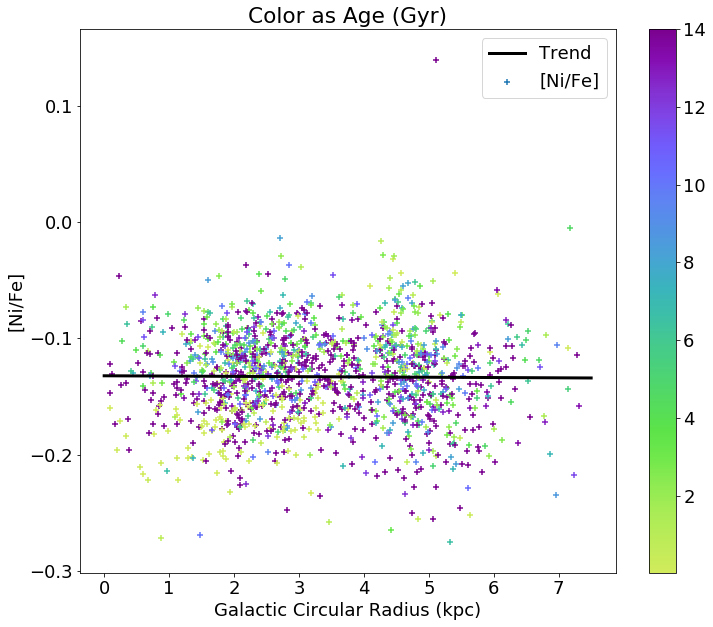

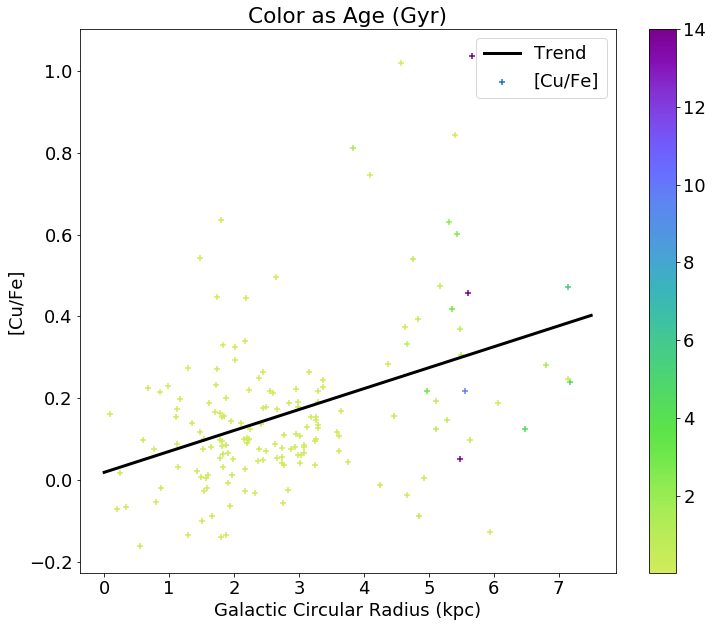

In [20]:
# import scipy.stats as st

radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

matplotlib.rcParams.update({'font.size': 18})
for i in range(len(elems)-5):
    xval = np.linspace(0.0,7.5)
    def trendline(x):
        return elems_slope[i]*x+elems_inter[i]
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    plt.figure(figsize=[12,10])
    plt.scatter(radius[cln],r13[elems[i]][cln],marker='+',c=(10**parage[cln])/10**9,label='{}'.format(labs[i]),
                cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,vmax=14)
    plt.plot(xval,trendline(xval),c='k',lw=3.0,label='Trend')
    plt.legend(loc='upper right')
    plt.title(r'Color as Age (Gyr)')
    plt.ylabel(r'{}'.format(labs[i]))
    plt.xlabel(r'Galactic Circular Radius (kpc)')
    #plt.xlabel(r'Large Magellanic Cloud Galactic Plane Radius (kpc)')
    plt.colorbar()

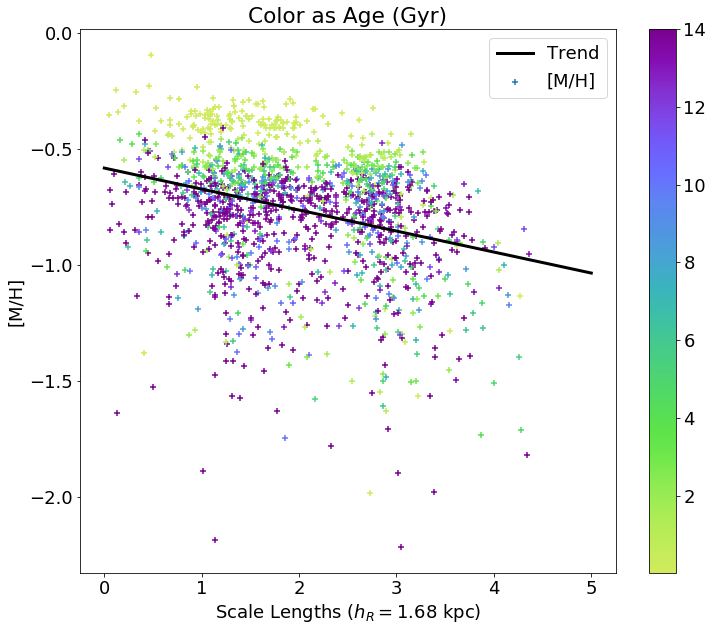

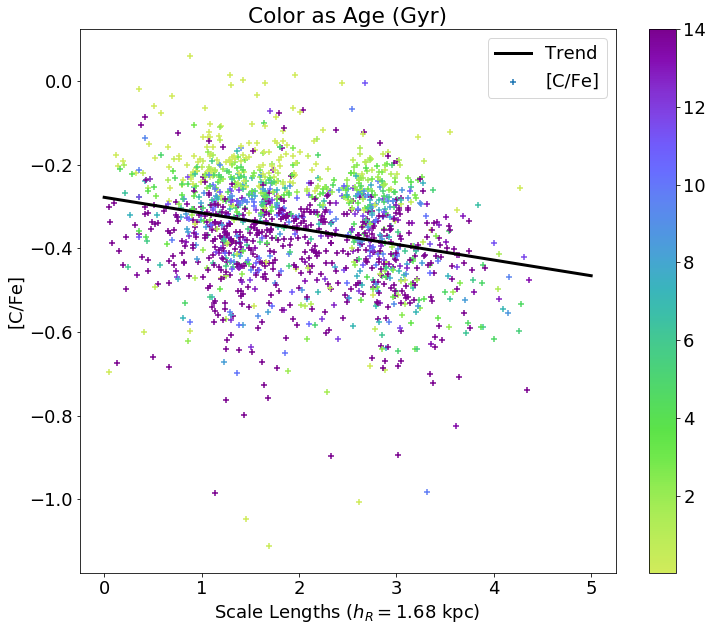

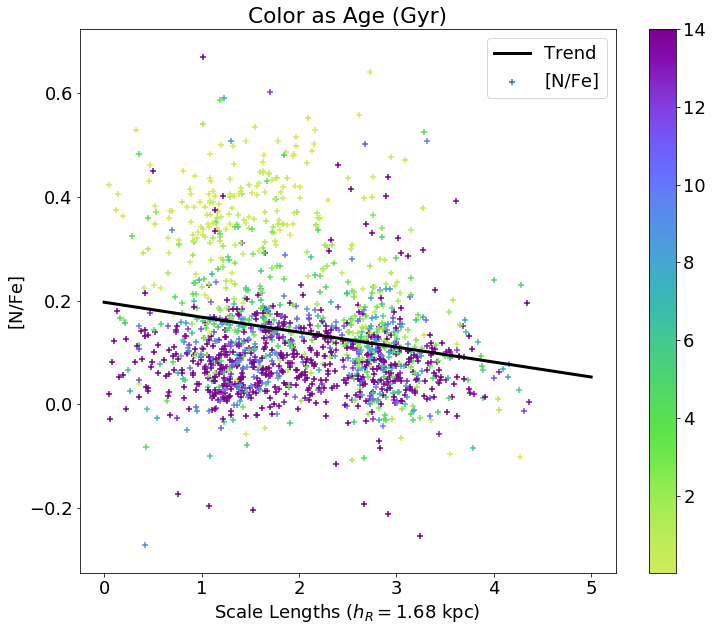

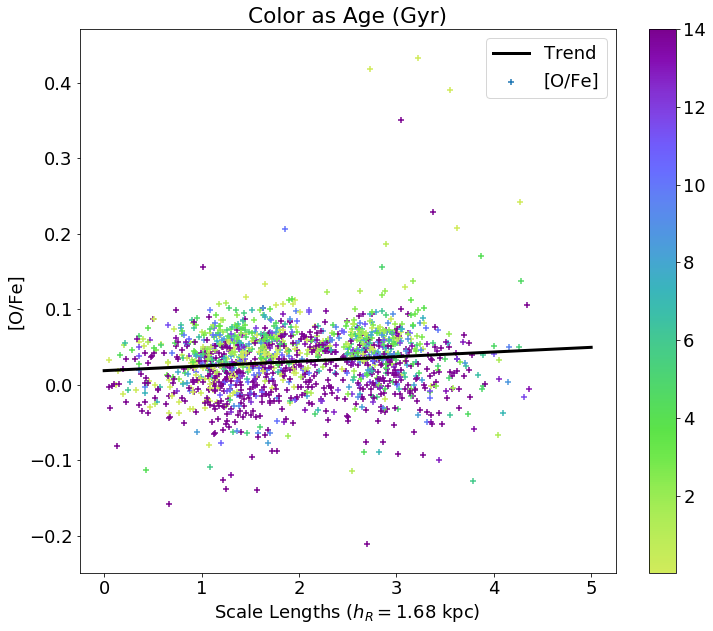

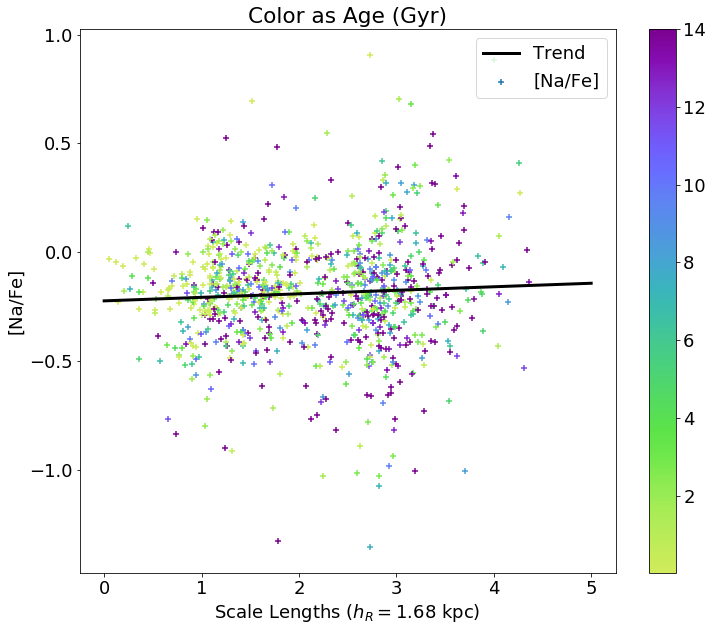

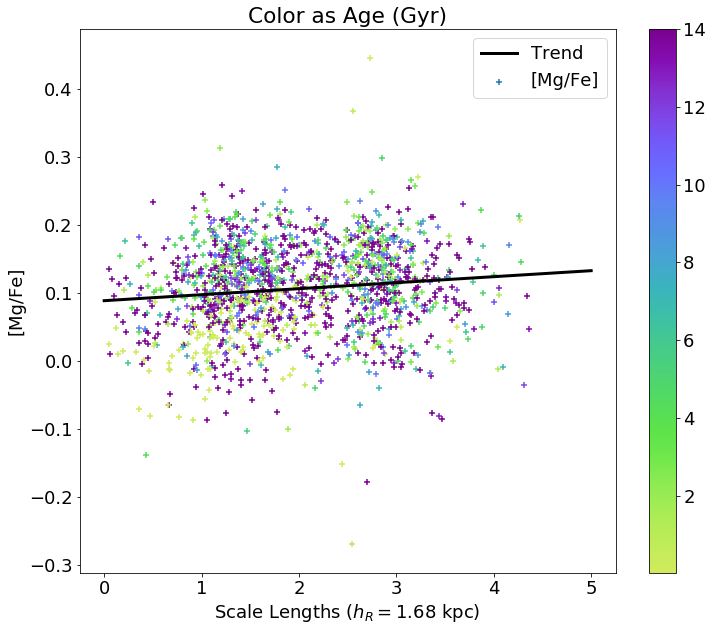

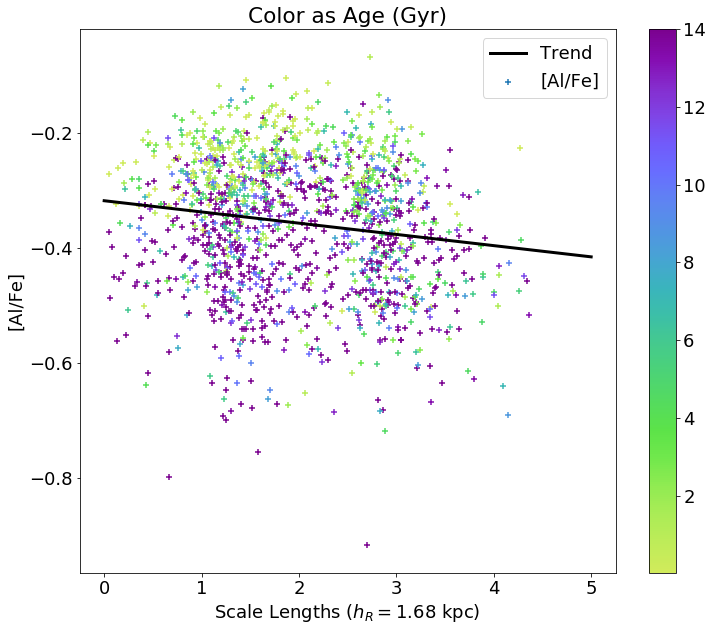

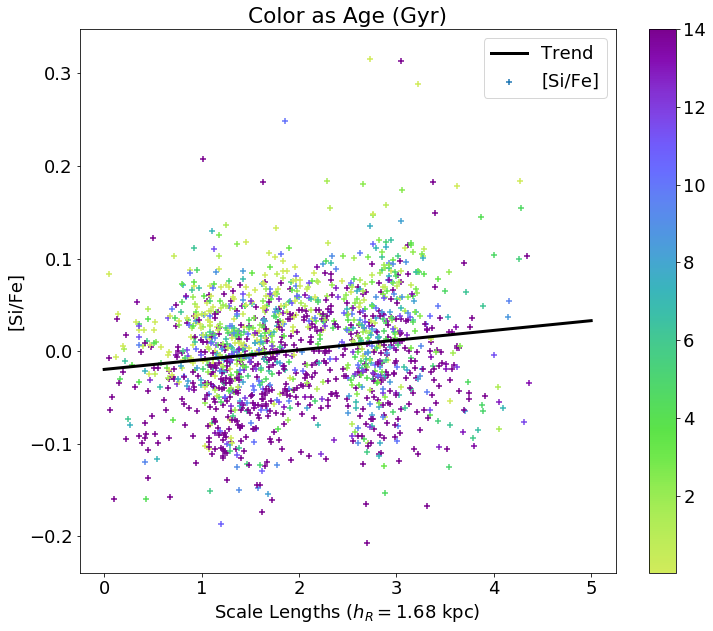

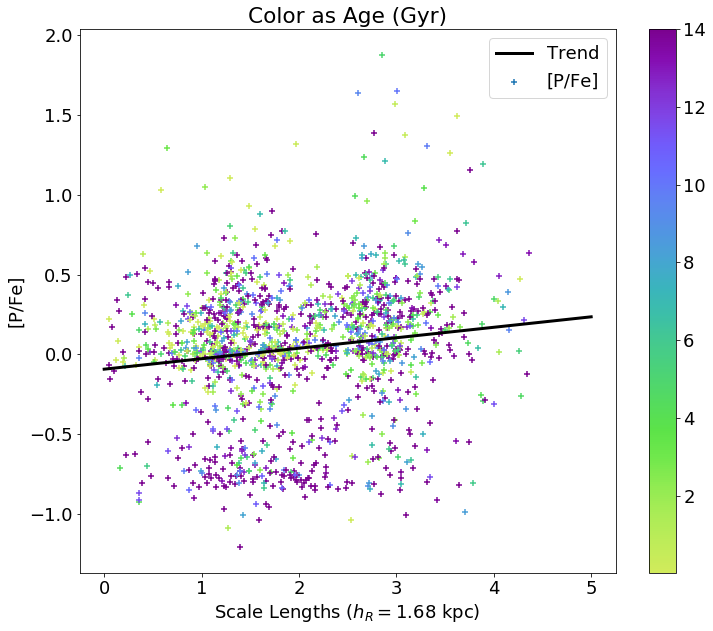

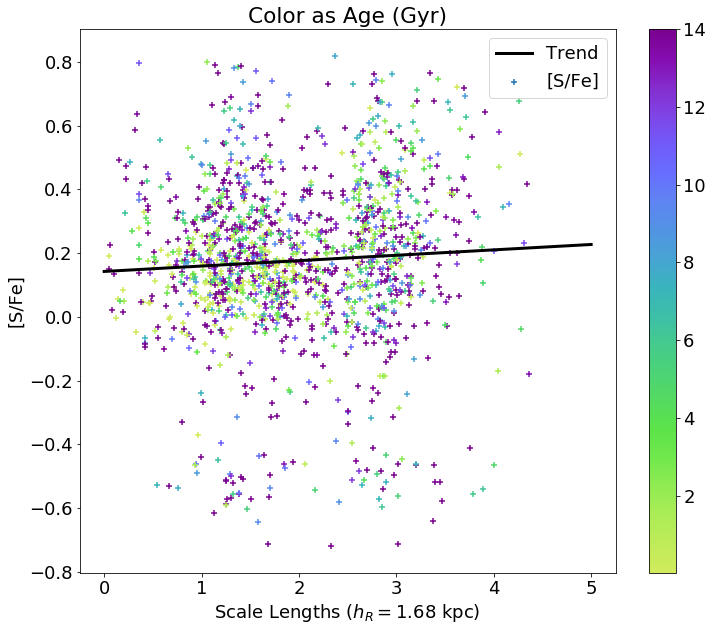

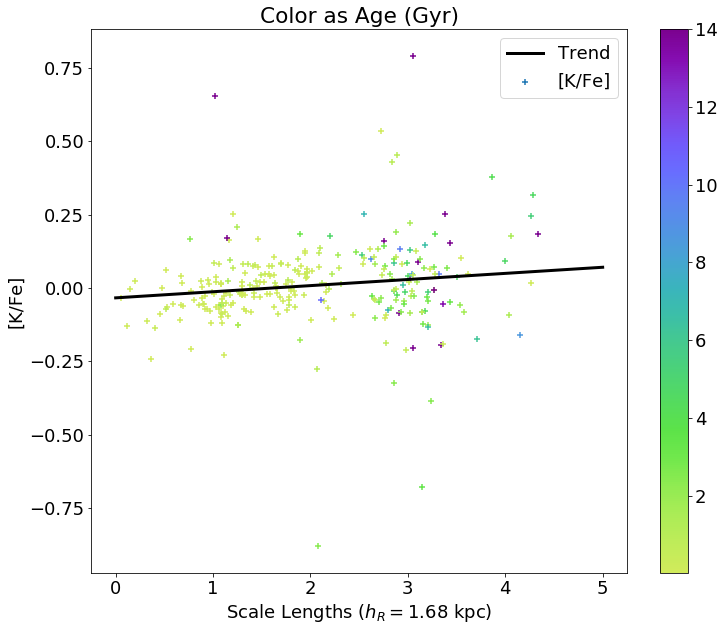

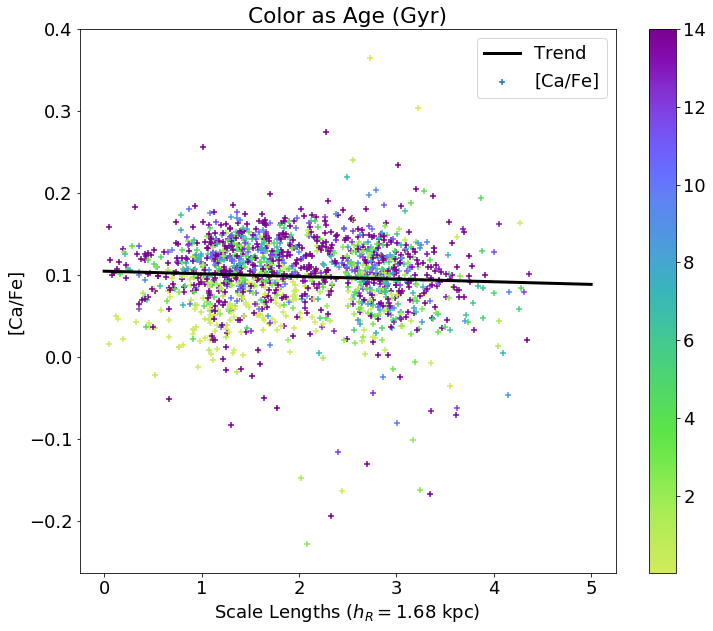

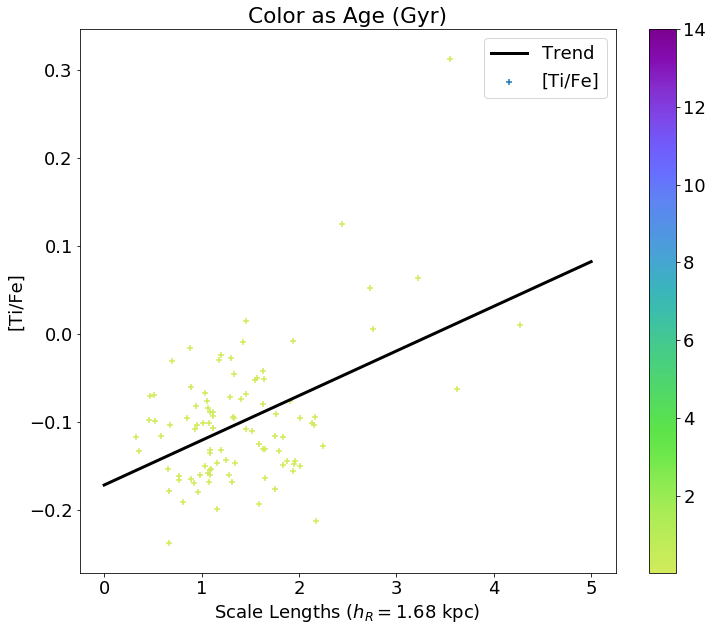

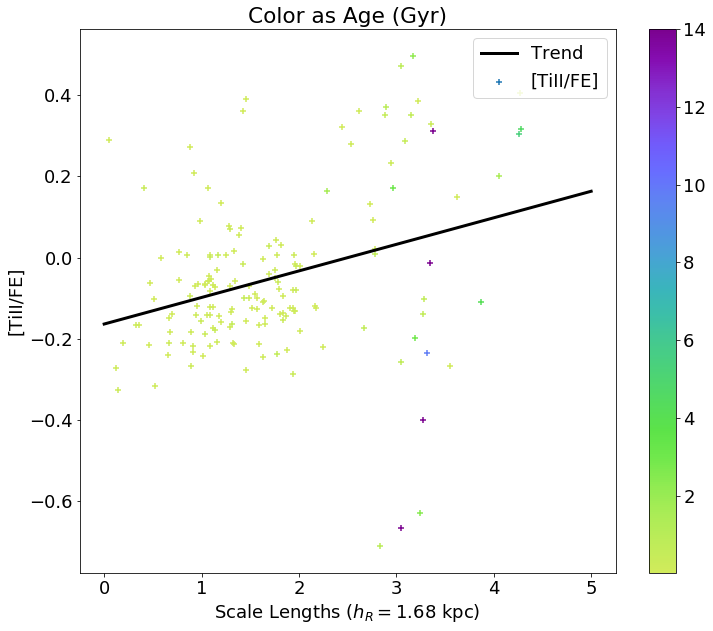

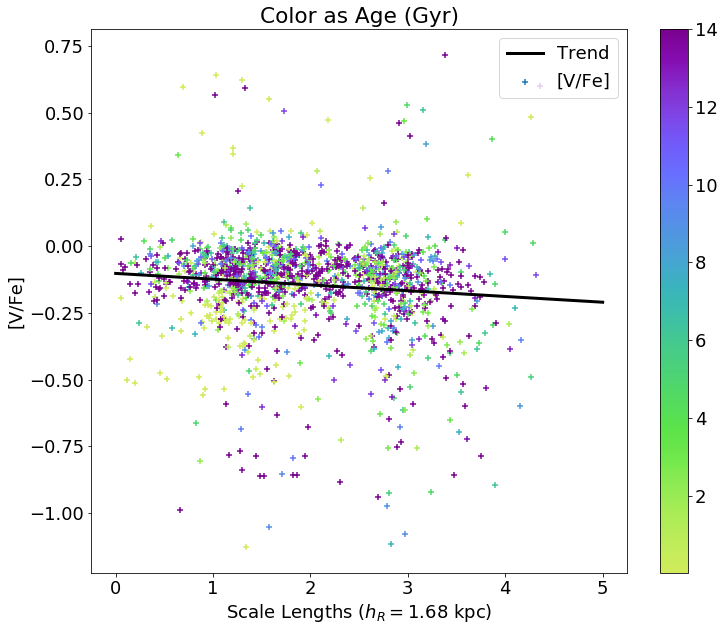

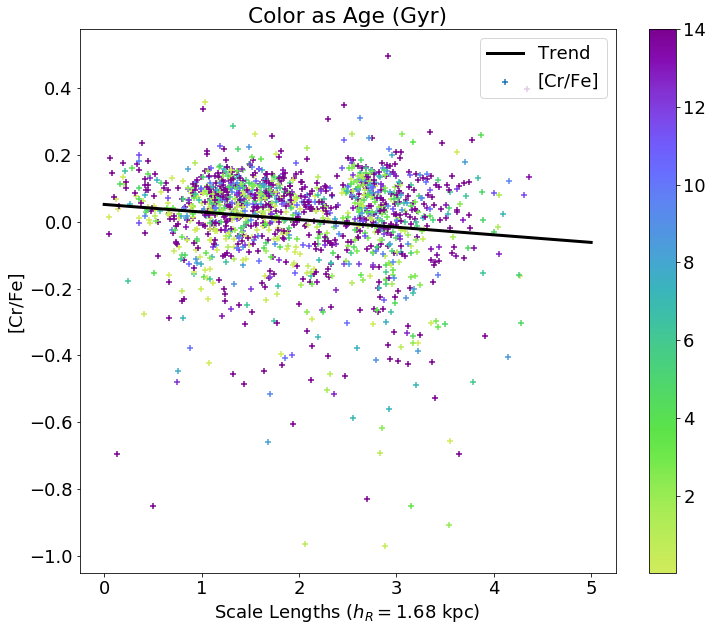

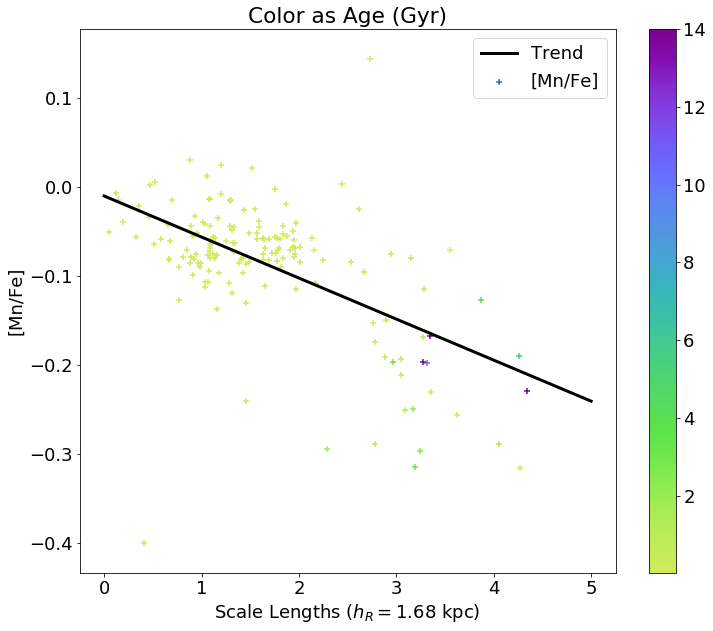

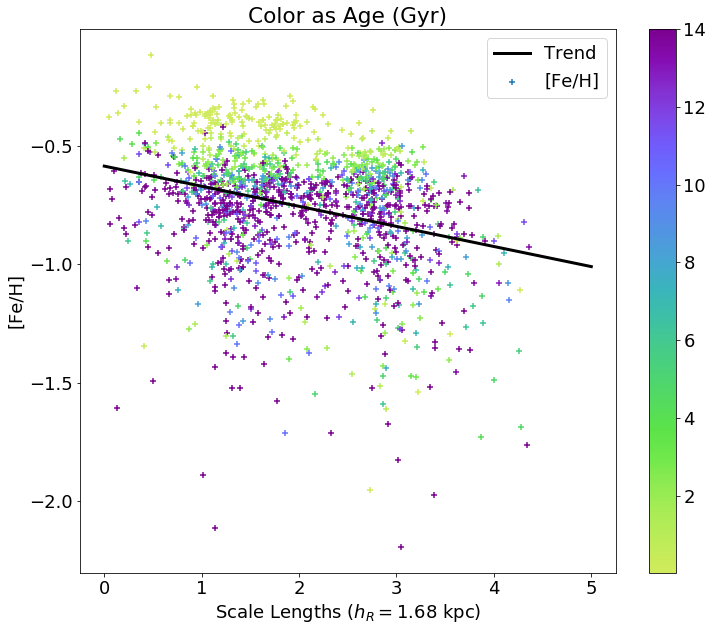

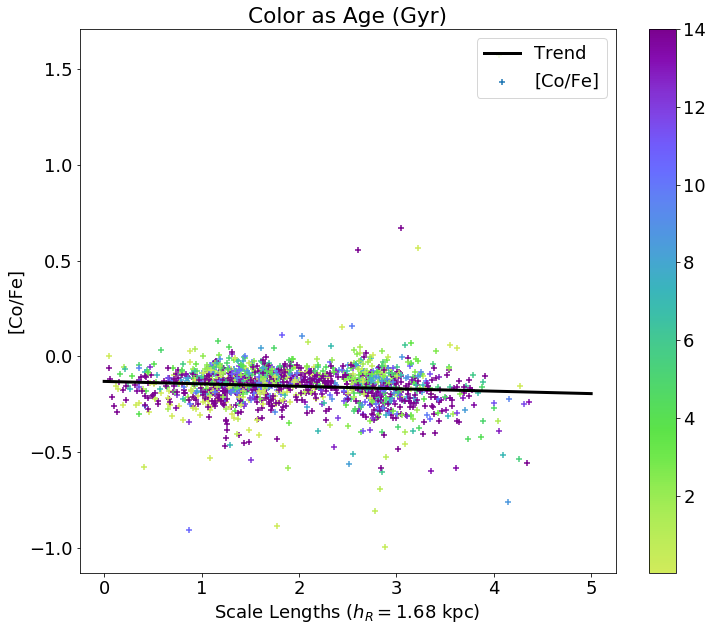

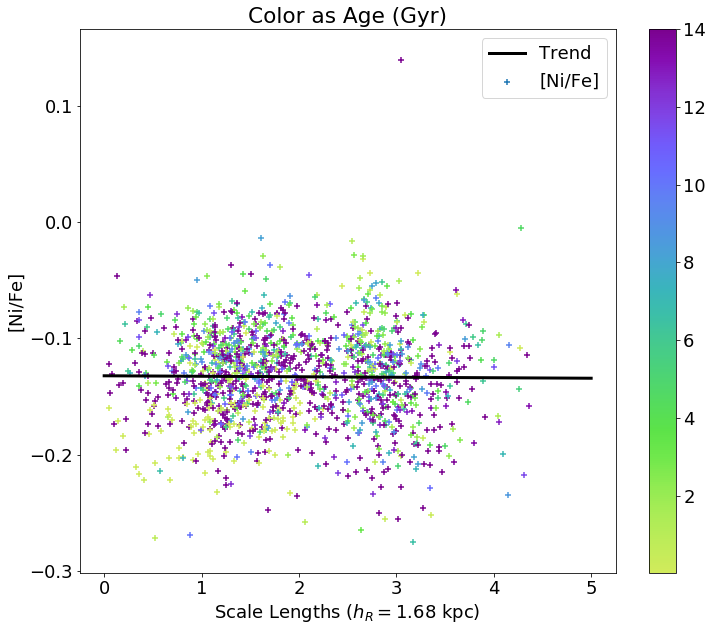

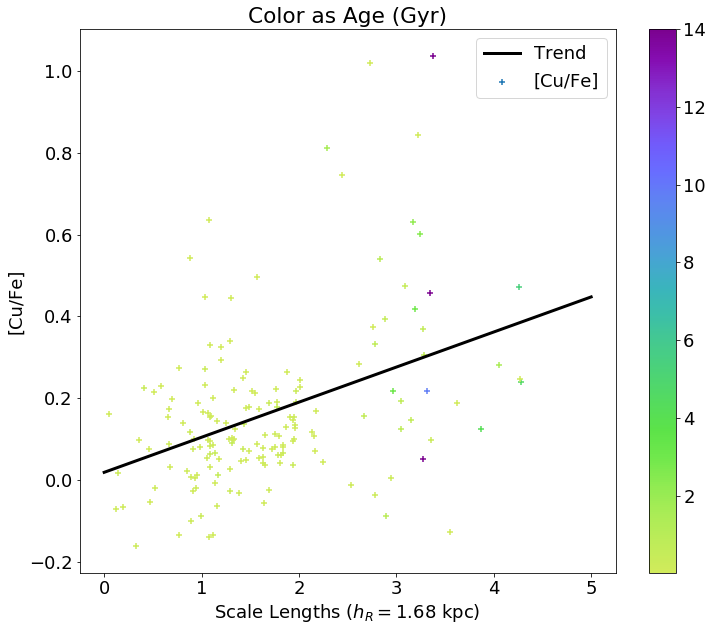

In [21]:
### same as cell above just scaled to the scale lengt of 1.68 kpc
matplotlib.rcParams.update({'font.size': 18})
for i in range(len(elems)-5):
    xval = np.linspace(0.0,5.0)
    def trendline(x):
        return scelems_slope[i]*x+scelems_inter[i]
    cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100)&(kthbitset(r13['ASPCAPFLAG'],23)=='False'))
    plt.figure(figsize=[12,10])
    plt.scatter(radius[cln]*0.59643876,r13[elems[i]][cln],marker='+',c=(10**parage[cln])/10**9,label='{}'.format(labs[i]),
                cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,vmax=14)
    plt.plot(xval,trendline(xval),c='k',lw=3.0,label='Trend')
    plt.legend(loc='upper right')
    plt.title(r'Color as Age (Gyr)')
    plt.ylabel(r'{}'.format(labs[i]))
    plt.xlabel(r'Scale Lengths ($h_{R} = 1.68$ kpc)')
    #plt.xlabel(r'Large Magellanic Cloud Galactic Plane Radius (kpc)')
    plt.colorbar()

$\Huge{\text{AGE BINS BELOW}}$

In [22]:
################
### Age Bins ###
################

young = np.where(parage<=np.log10(3.5*10**9))
ymed = np.where((parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
old = np.where(parage>np.log10(10.5*10**9))
# print(ymed)

In [23]:
##########################################
### Calculate Gradients and intercepts ###
##########################################

### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']


### young ###
young_elems_slope = []
young_elems_inter = []

r13young = r13[young]
radiusyoung = radius[young]

for i in range(len(elems)):
    cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100)&(kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([radiusyoung[cln],np.ones(len(radiusyoung[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13young[elems[i]][cln])[0]
    young_elems_slope.append(mi)
    young_elems_inter.append(ci)
    
print('### young Age <= 3.5  Gyr ###')

for j in range(len(elems)):
    print(elems[j]+' slope: '+str(young_elems_slope[j])+ ' inter: '+ str(young_elems_inter[j]))

### ymed ###
print('### ymed  3.5< Age <=7.0 Gyr ###')
ymed_elems_slope = []
ymed_elems_inter = []

r13ymed = r13[ymed]
radiusymed = radius[ymed]

for i in range(len(elems)):
    cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100)&(kthbitset(r13ymed['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([radiusymed[cln],np.ones(len(radiusymed[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13ymed[elems[i]][cln])[0]
    ymed_elems_slope.append(mi)
    ymed_elems_inter.append(ci)
    
for j in range(len(elems)):
    print(elems[j]+' slope: '+str(ymed_elems_slope[j])+ ' inter: '+ str(ymed_elems_inter[j]))
    
### omed ###
print('### omed  7.0< Age <=10.5 Gyr ###')
omed_elems_slope = []
omed_elems_inter = []

r13omed = r13[omed]
radiusomed = radius[omed]

for i in range(len(elems)):
    cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100)&(kthbitset(r13omed['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([radiusomed[cln],np.ones(len(radiusomed[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13omed[elems[i]][cln])[0]
    omed_elems_slope.append(mi)
    omed_elems_inter.append(ci)
    
# for j in range(len(elems)):
#     print(elems[j]+' slope: '+str(omed_elems_slope[j])+ ' inter: '+ str(omed_elems_inter[j]))
    
### old ###
print('### old  10.5< Age Gyr ###')
old_elems_slope = []
old_elems_inter = []

r13old = r13[old]
radiusold = radius[old]

for i in range(len(elems)):
    cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100)&(kthbitset(r13old['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([radiusold[cln],np.ones(len(radiusold[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13old[elems[i]][cln])[0]
    old_elems_slope.append(mi)
    old_elems_inter.append(ci)
    
for j in range(len(elems)):
    print(elems[j]+' slope: '+str(old_elems_slope[j])+ ' inter: '+ str(old_elems_inter[j]))

### young Age <= 3.5  Gyr ###
M_H slope: -0.09163413251906832 inter: -0.2980980029319158
C_FE slope: -0.027674802884040742 inter: -0.1859226705134996
N_FE slope: -0.045422029050814765 inter: 0.39851573214242764
O_FE slope: 0.011720736050449716 inter: 0.010222102869140973
NA_FE slope: 0.014167524351454477 inter: -0.20124983853623302
MG_FE slope: 0.0157642273832099 inter: 0.04323885575093486
AL_FE slope: -0.01633326208576971 inter: -0.23239646423148072
SI_FE slope: 0.00939554767689417 inter: 0.002832403943491484
P_FE slope: 0.01618280765327931 inter: 0.0958061331959821
S_FE slope: 0.04271304941953724 inter: 0.04921158551296556
K_FE slope: 0.007547219543641726 inter: -0.028454202008440246
CA_FE slope: 0.0028530511841459924 inter: 0.06711136787334844
TI_FE slope: 0.030329166706364114 inter: -0.17210918925827853
TIII_FE slope: 0.04612127321432841 inter: -0.17625945845239063
V_FE slope: 0.0046454830040673885 inter: -0.16748896773366537
CR_FE slope: -0.02768235251617799 inter: 0.0772016159016

In [24]:
####
### Age binned scaled

### young ###
scyoung_elems_slope = []
scyoung_elems_inter = []

r13young = r13[young]
scradiusyoung = radius[young]*0.59643876

for i in range(len(elems)):
    cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100)&(kthbitset(r13young['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([scradiusyoung[cln],np.ones(len(radiusyoung[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13young[elems[i]][cln])[0]
    scyoung_elems_slope.append(mi)
    scyoung_elems_inter.append(ci)
    
# print('### young Age <= 3.5  Gyr ###')

# for j in range(len(elems)):
#     print(elems[j]+' slope: '+str(young_elems_slope[j])+ ' inter: '+ str(young_elems_inter[j]))

### ymed ###
# print('### ymed  3.5< Age <=7.0 Gyr ###')
scymed_elems_slope = []
scymed_elems_inter = []

r13ymed = r13[ymed]
scradiusymed = radius[ymed]*0.59643876

for i in range(len(elems)):
    cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100)&(kthbitset(r13ymed['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([scradiusymed[cln],np.ones(len(radiusymed[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13ymed[elems[i]][cln])[0]
    scymed_elems_slope.append(mi)
    scymed_elems_inter.append(ci)
    
# for j in range(len(elems)):
#     print(elems[j]+' slope: '+str(scymed_elems_slope[j])+ ' inter: '+ str(scymed_elems_inter[j]))
    
### omed ###
# print('### omed  7.0< Age <=10.5 Gyr ###')
scomed_elems_slope = []
scomed_elems_inter = []

r13omed = r13[omed]
scradiusomed = radius[omed]*0.59643876

for i in range(len(elems)):
    cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100)&(kthbitset(r13omed['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([scradiusomed[cln],np.ones(len(radiusomed[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13omed[elems[i]][cln])[0]
    scomed_elems_slope.append(mi)
    scomed_elems_inter.append(ci)
    
# for j in range(len(elems)):
#     print(elems[j]+' slope: '+str(omed_elems_slope[j])+ ' inter: '+ str(omed_elems_inter[j]))
    
### old ###
# print('### old  10.5< Age Gyr ###')
scold_elems_slope = []
scold_elems_inter = []

r13old = r13[old]
scradiusold = radius[old]*0.59643876

for i in range(len(elems)):
    cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100)&(kthbitset(r13old['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([scradiusold[cln],np.ones(len(radiusold[cln]))]).T
    mi, ci = np.linalg.lstsq(A, r13old[elems[i]][cln])[0]
    scold_elems_slope.append(mi)
    scold_elems_inter.append(ci)
    
# for j in range(len(elems)):
#     print(elems[j]+' slope: '+str(scold_elems_slope[j])+ ' inter: '+ str(scold_elems_inter[j]))

In [25]:
# radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1])

# labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
#         '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
#         '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
# els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
#        'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

# matplotlib.rcParams.update({'font.size': 18})

# young_parage = parage[young]
# ymed_parage = parage[ymed]
# omed_parage = parage[omed]
# old_parage = parage[old]

# for i in range(len(elems)-5):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return young_elems_slope[i]*x+young_elems_inter[i]
#     def ymedtrendline(x):
#         return ymed_elems_slope[i]*x+ymed_elems_inter[i]
#     def omedtrendline(x):
#         return omed_elems_slope[i]*x+omed_elems_inter[i]
#     def oldtrendline(x):
#         return old_elems_slope[i]*x+old_elems_inter[i]
    
#     young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
#     ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
#     omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
#     old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    
#     fig = plt.figure(figsize=[12,10])
    
#     plt.scatter(radius[young][young_cln],r13young[elems[i]][young_cln],marker='+',label='$0.0 < \\tau \leq 3.5$ Gyr',
#                 c='blue')
#     plt.plot(xval,youngtrendline(xval),c='blue',lw=3.0,label='$0.0 < \\tau \leq 3.5$ Gyr') #young
    
#     plt.scatter(radius[ymed][ymed_cln],r13ymed[elems[i]][ymed_cln],marker='+',label='$3.5 < \\tau \leq 7.5$ Gyr',
#                 c='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,label='$3.5 < \\tau \leq 7.5$ Gyr') #ymed
    
#     plt.scatter(radius[omed][omed_cln],r13omed[elems[i]][omed_cln],marker='+',label='$7.0 < \\tau \leq 10.5$ Gyr',
#                 c='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,label='$7.0 < \\tau \leq 10.5$ Gyr') #omed
    
#     plt.scatter(radius[old][old_cln],r13old[elems[i]][old_cln],marker='+',label='$10.5 < \\tau$ Gyr',
#                 c='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,label='$10.5 < \\tau$ Gyr') #old
    
#     ###Overall Trend
#     def trendline(x):
#         return elems_slope[i]*x+elems_inter[i]
#     plt.plot(xval,trendline(xval),c='k',lw=3.0,label='Overall Trend')
   
#     plt.legend(loc='upper right',fontsize='xx-small')
# #     plt.title(r'{} Gradients, Color as Age (Gyr)'.format(labs[i]))
#     plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
#     plt.xlabel(r'Scale Lengths ($h_{R} = 1.68$ kpc)')
    
#     ax0 = fig.add_subplot(111)
#     at0 = AnchoredText('$0.0 < \\tau \leq 3.5$ Gyr: {:5.3f} $\,dex/kpc$ \n $3.5 < \\tau \leq 7.5$ Gyr: {:5.3f} $\,dex/kpc$ \n $7.0 < \\tau \leq 10.5$ Gyr: {:5.3f} $\,dex/kpc$ \n $10.5 < \\tau$ Gyr: {:5.3f} $\,dex/kpc$'.format(young_elems_slope[i],ymed_elems_slope[i],omed_elems_slope[i],old_elems_slope[i]),
#                       prop=dict(size=12),frameon=False,loc='lower right',)
#     at0.patch.set_boxstyle("square")
#     ax0.add_artist(at0)
    
#     at1 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
#     at1.patch.set_boxstyle("square,pad=0.3")
#     ax0.add_artist(at1)
    
# #     at2 = 
    
#     plt.savefig('age_abund_grad{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()
    
#     ### color code text in legend no dups
#     # get slopes to line up and color code

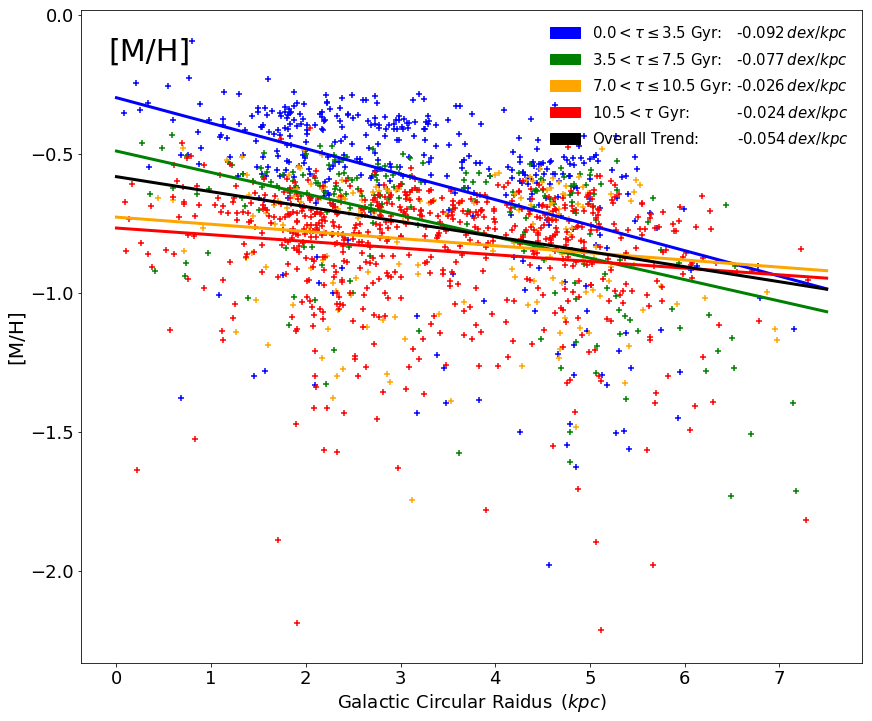

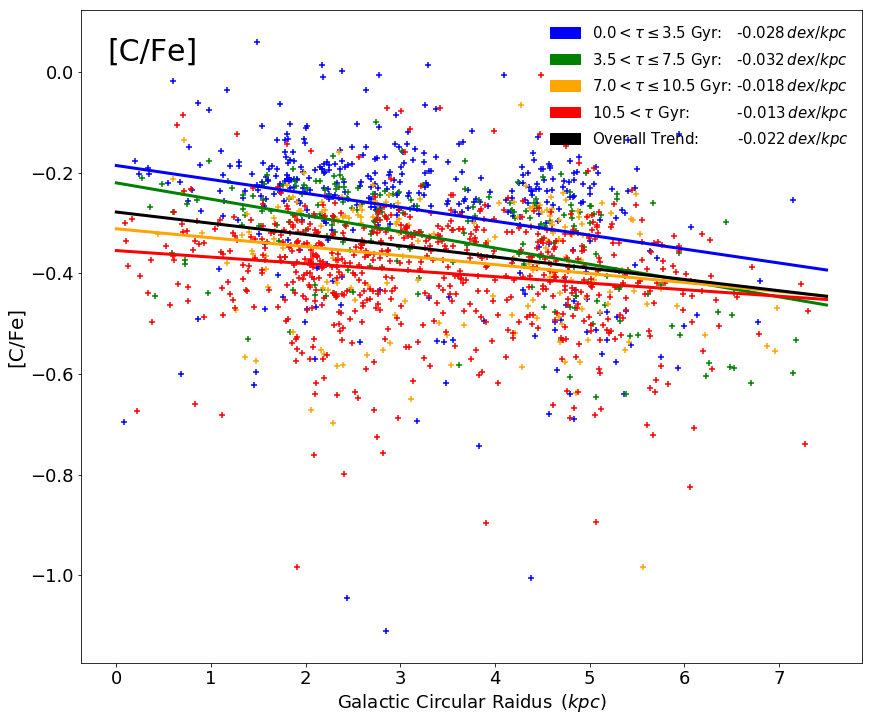

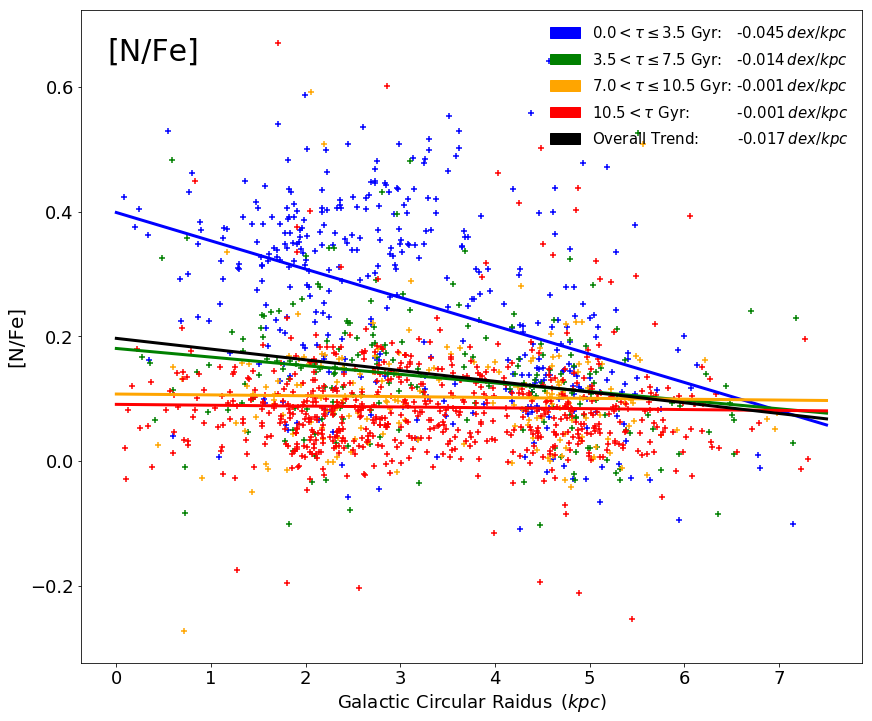

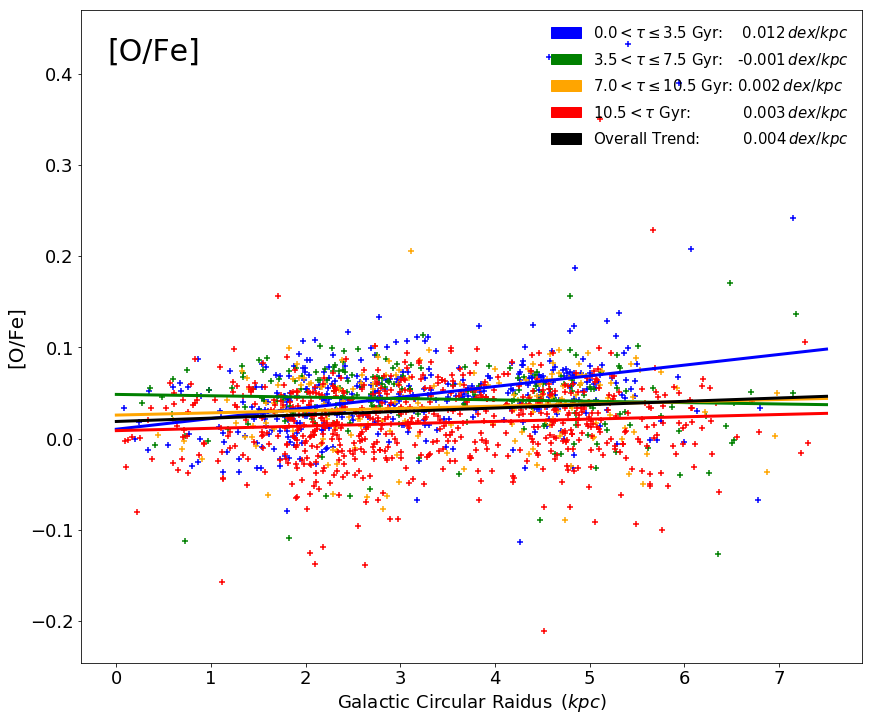

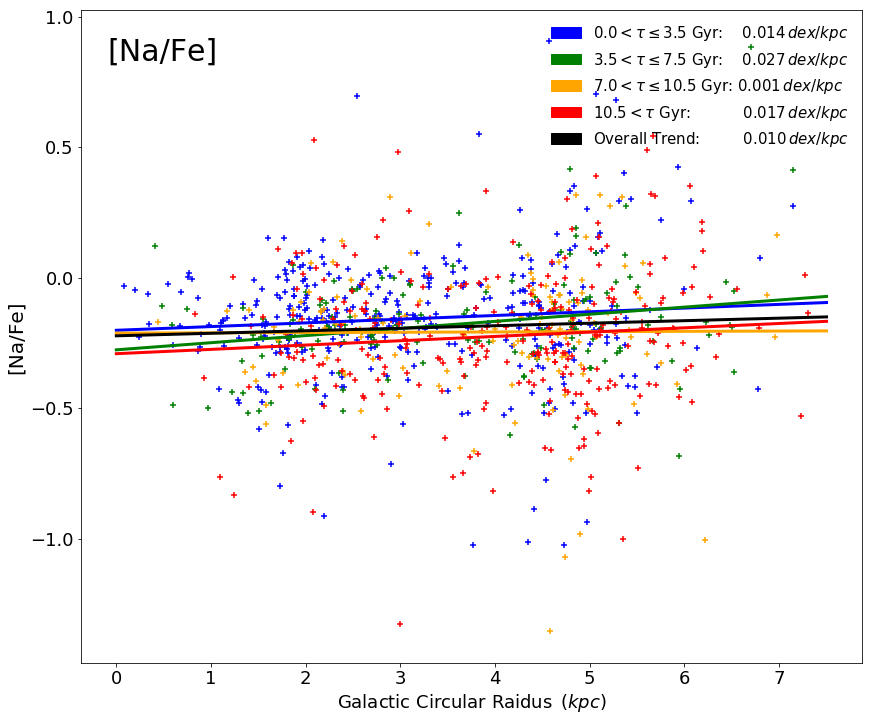

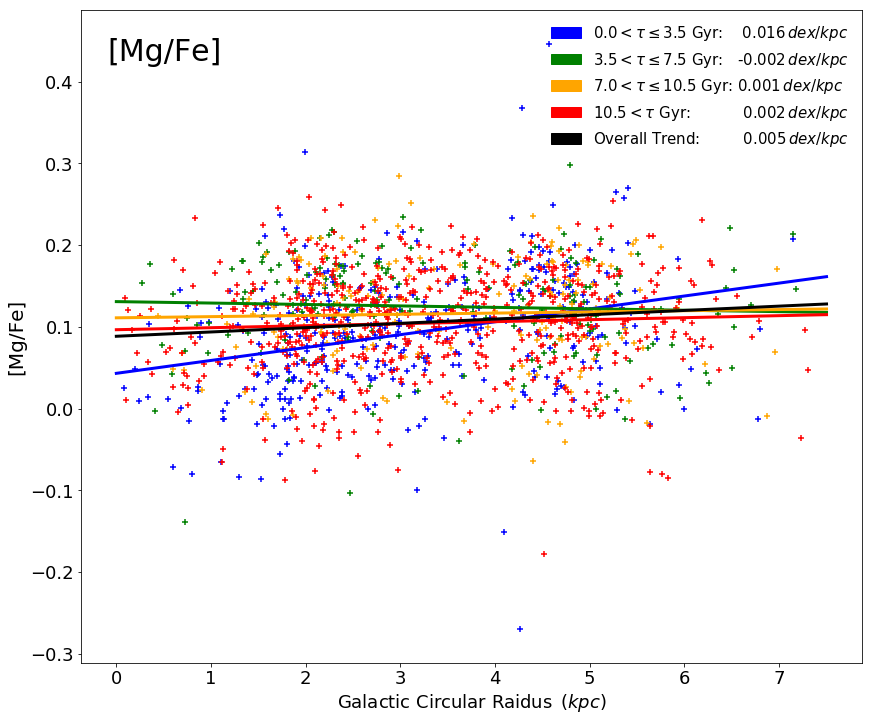

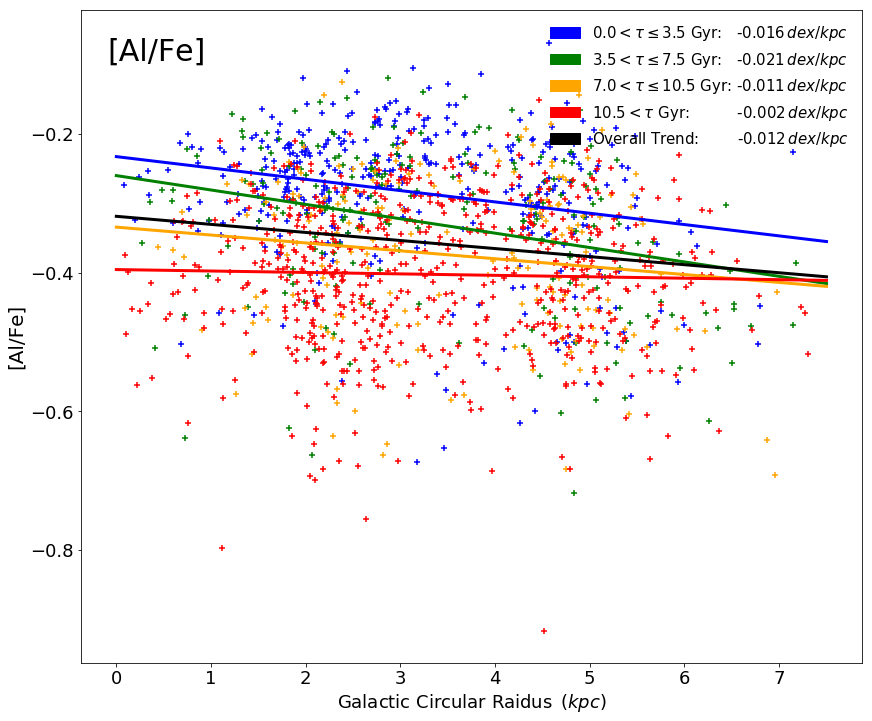

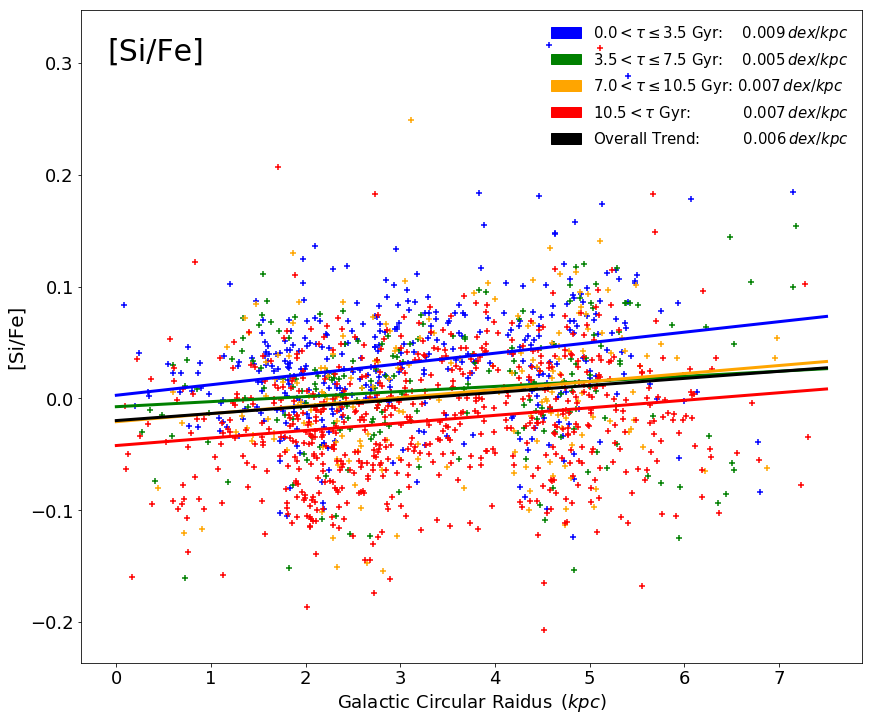

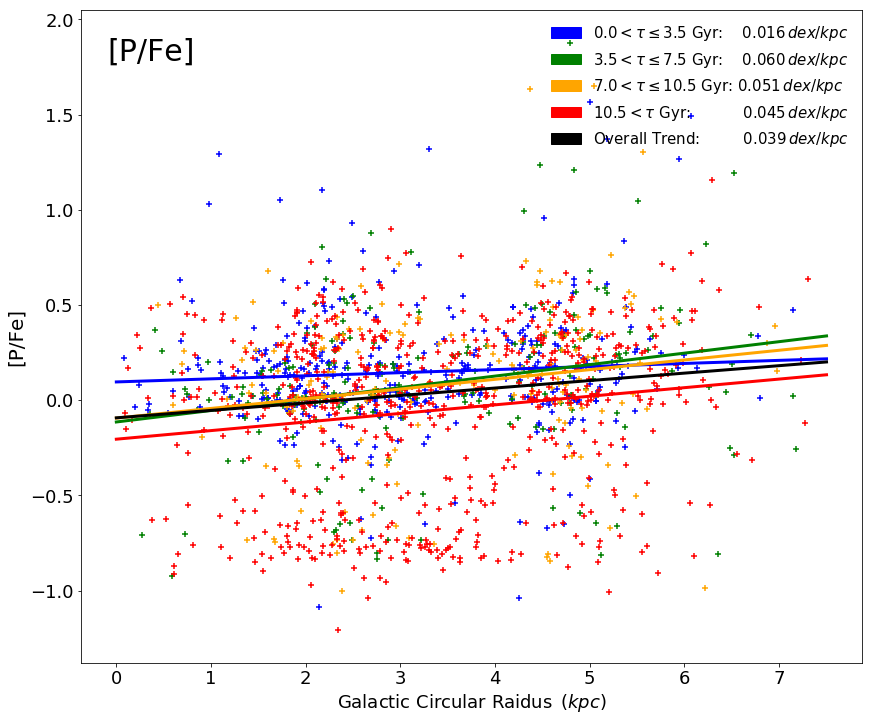

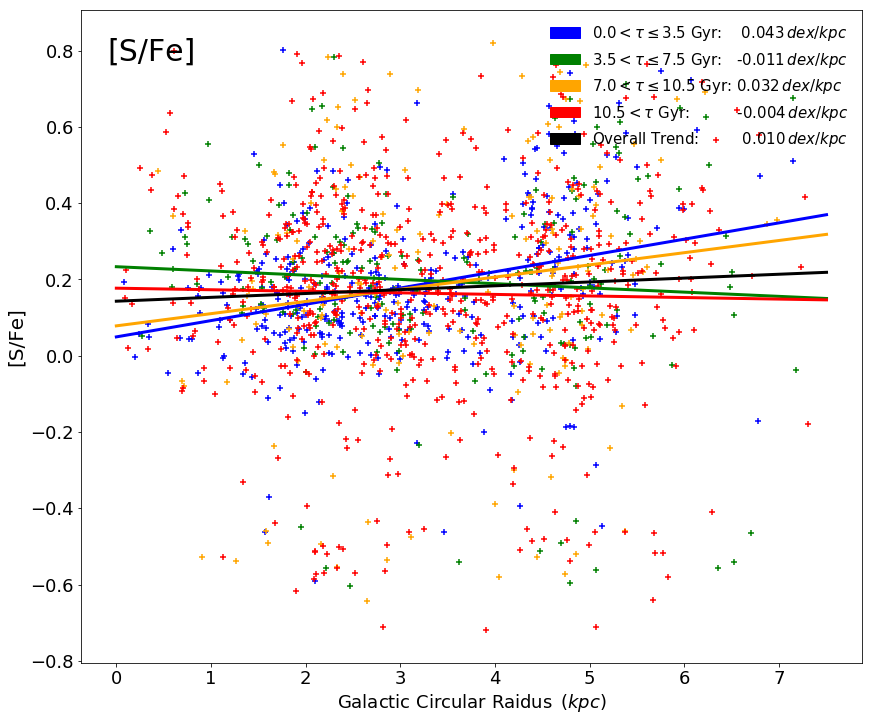

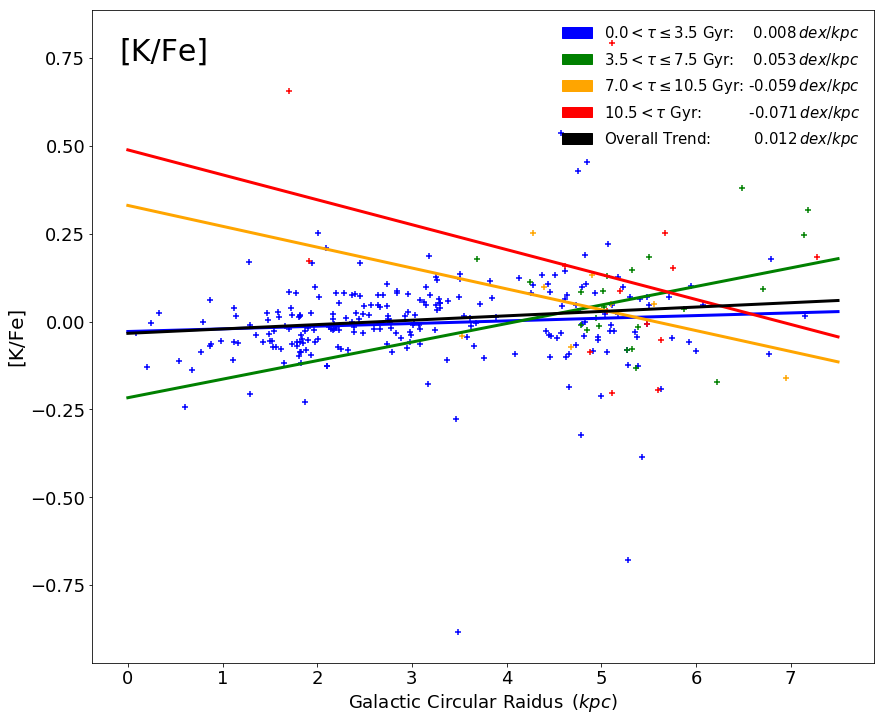

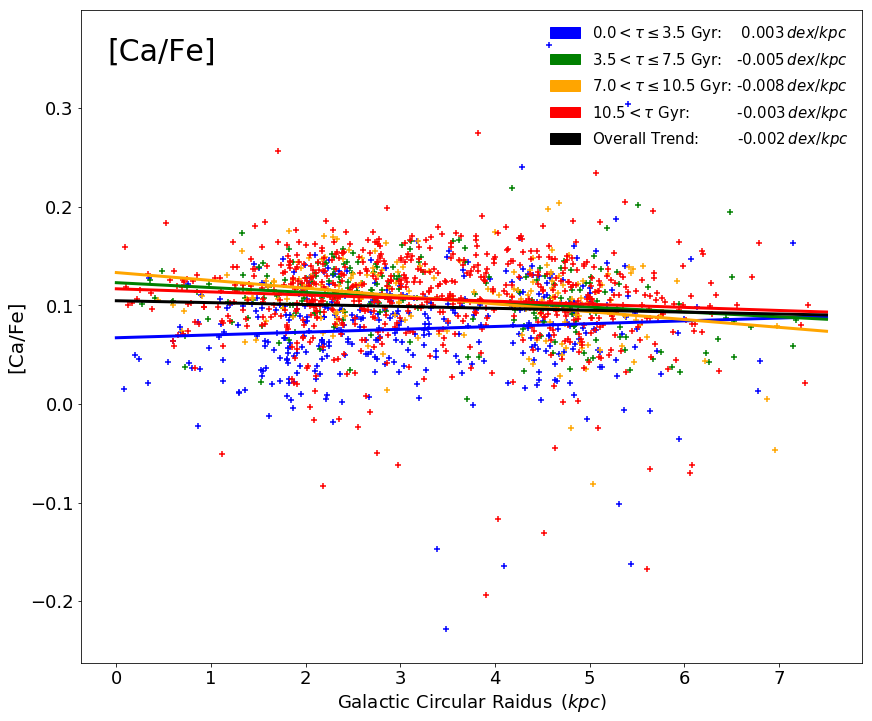

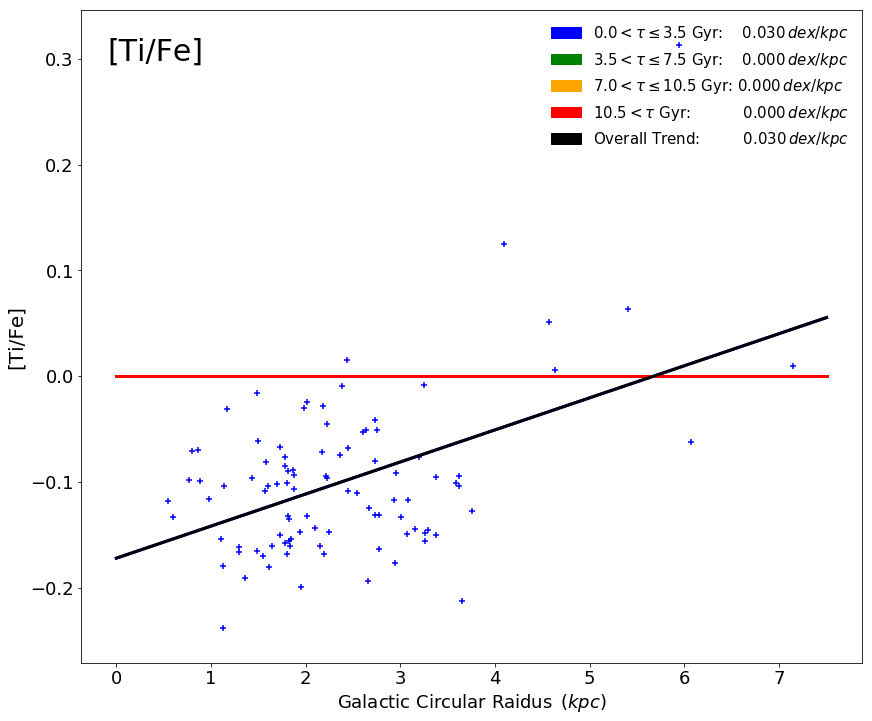

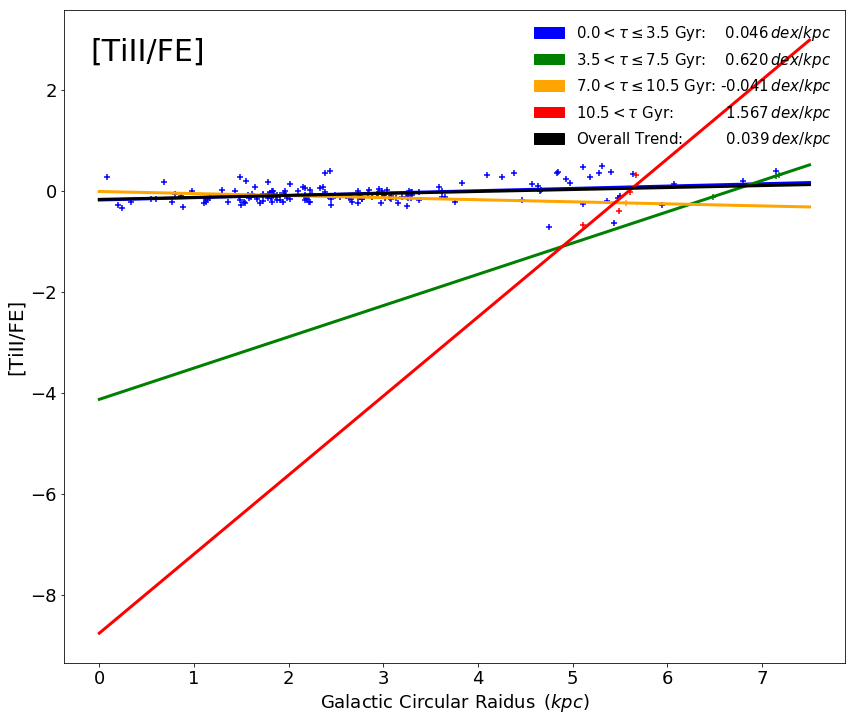

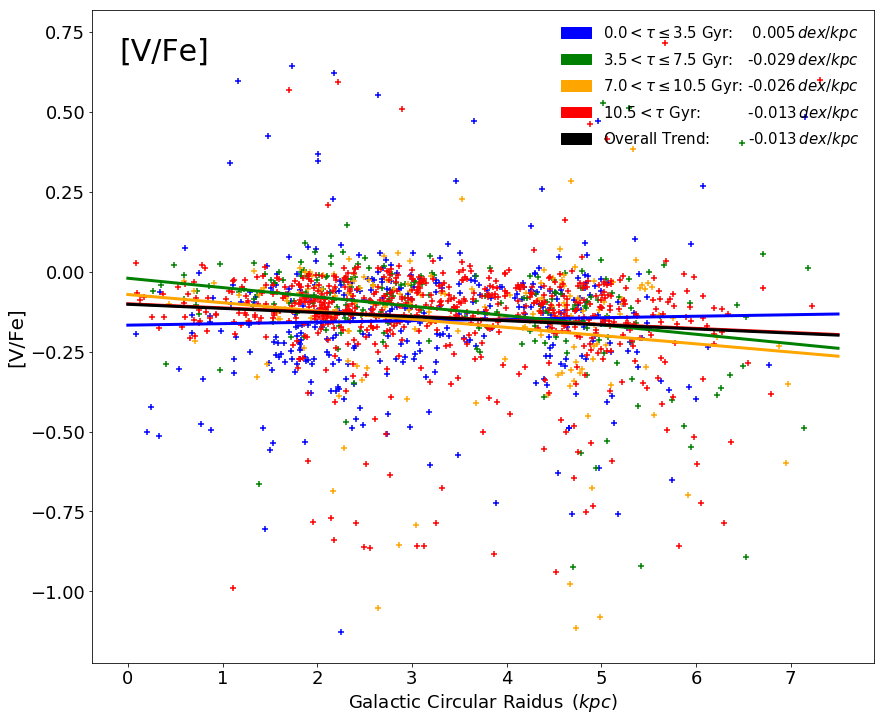

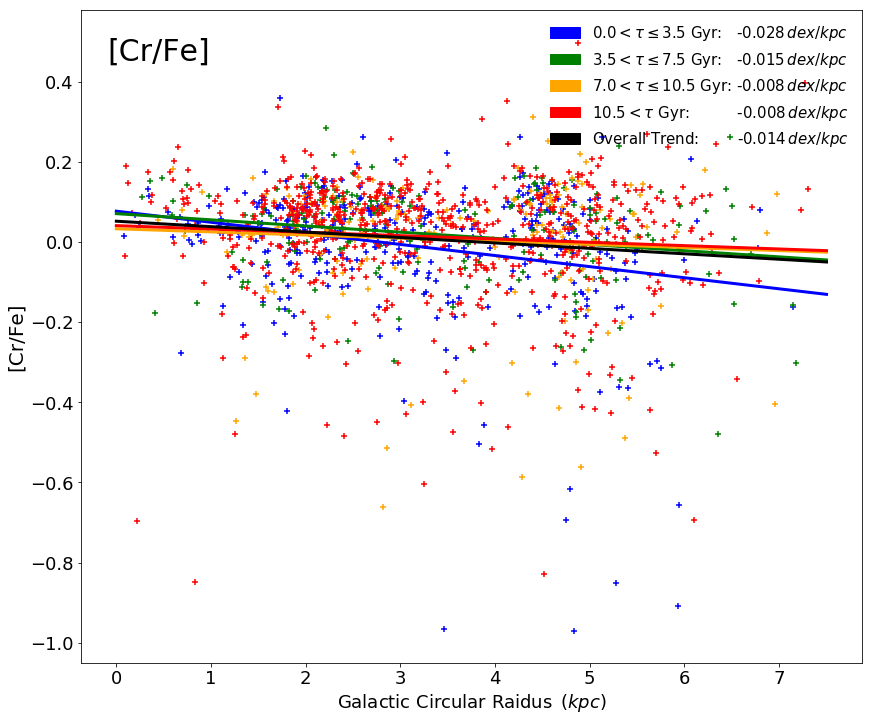

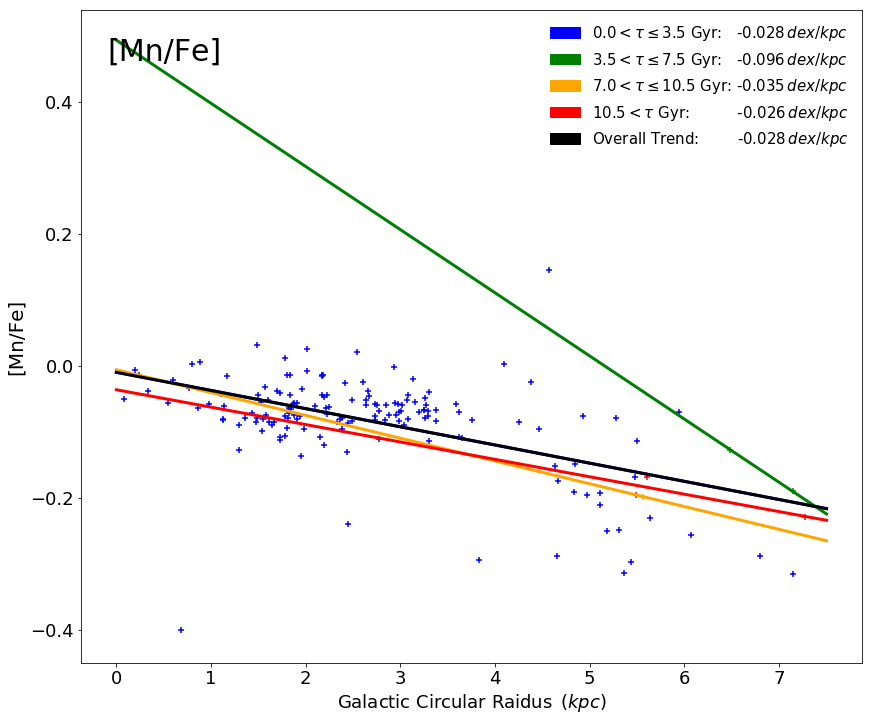

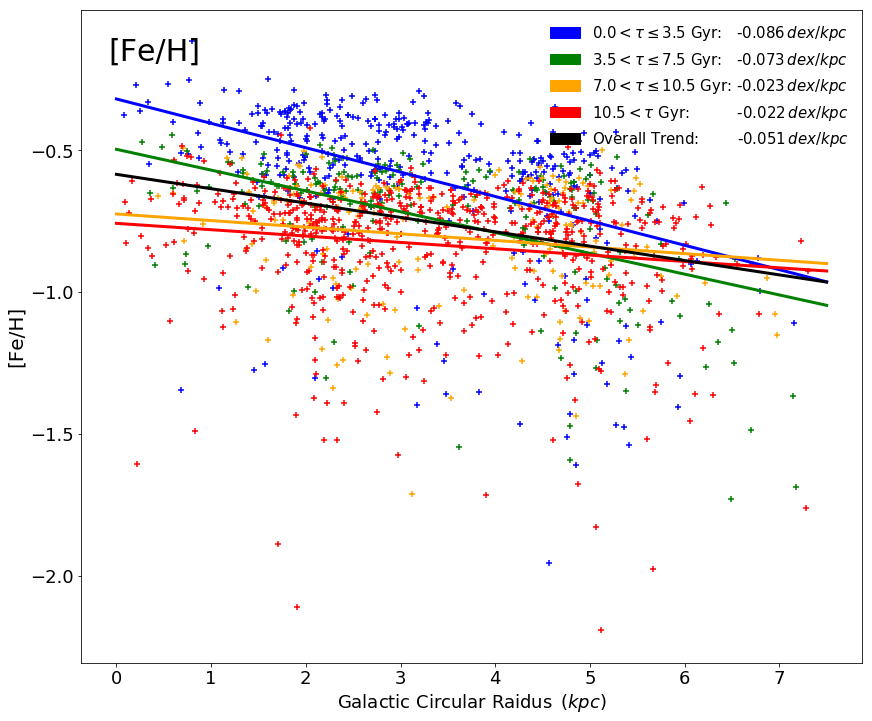

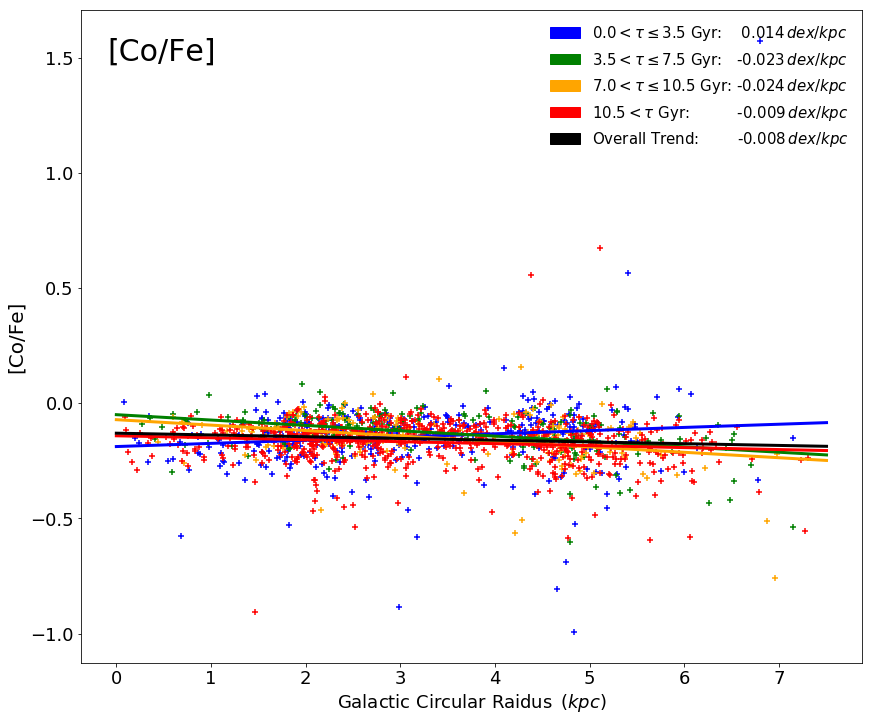

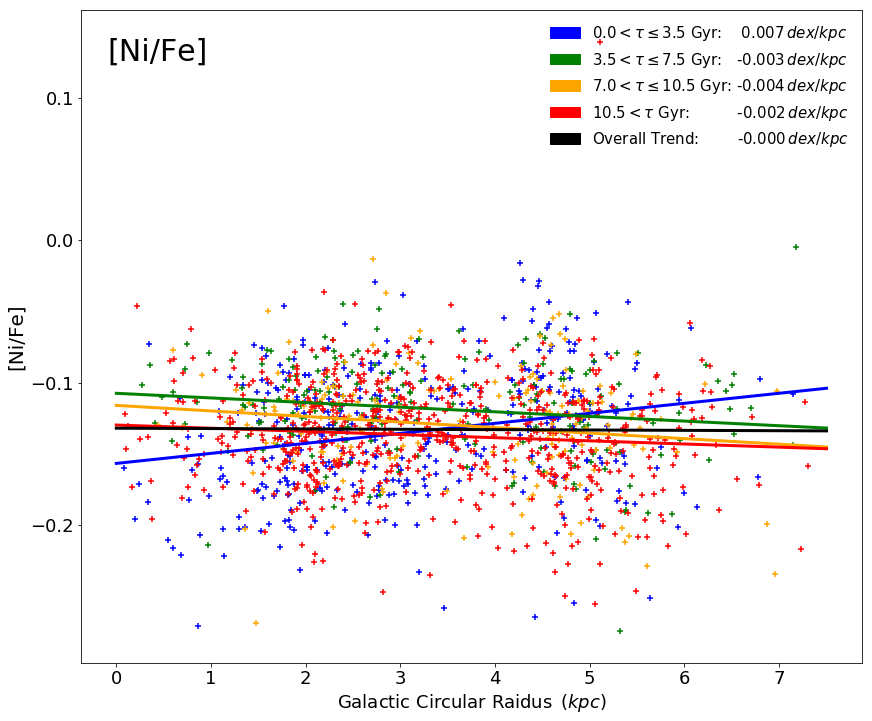

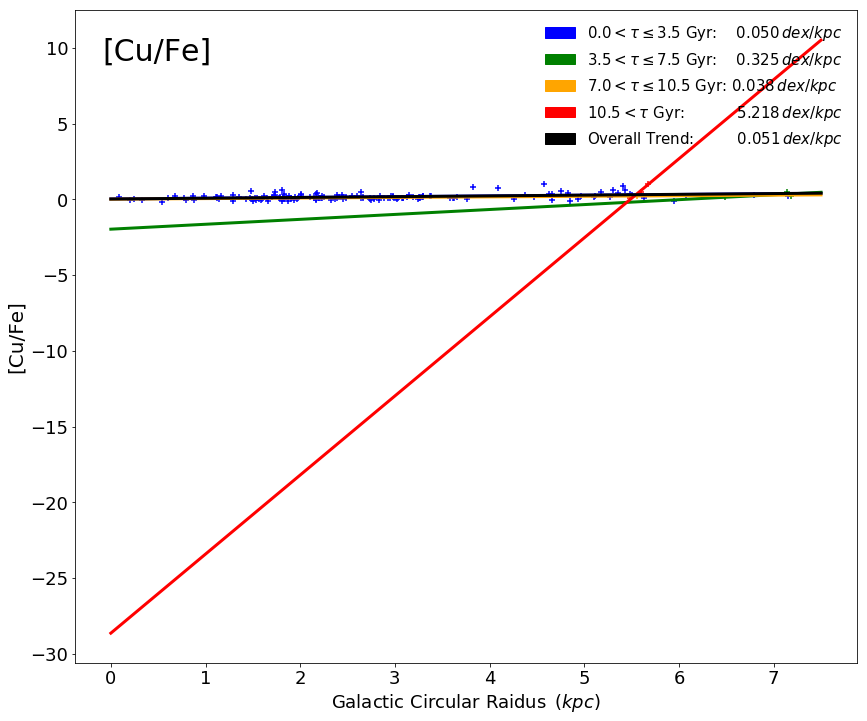

In [26]:
radius = np.sqrt(LMCdisk_cart(r13['RA'],r13['DEC'])[0]**2+LMCdisk_cart(r13['RA'],r13['DEC'])[1]**2)

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = parage[young]
ymed_parage = parage[ymed]
omed_parage = parage[omed]
old_parage = parage[old]

for i in range(len(elems)-5):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return young_elems_slope[i]*x+young_elems_inter[i]
    def ymedtrendline(x):
        return ymed_elems_slope[i]*x+ymed_elems_inter[i]
    def omedtrendline(x):
        return omed_elems_slope[i]*x+omed_elems_inter[i]
    def oldtrendline(x):
        return old_elems_slope[i]*x+old_elems_inter[i]
    
    young_cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    ymed_cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    omed_cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    old_cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])
    
    plt.scatter(radius[young][young_cln],r13young[elems[i]][young_cln],marker='+',c='blue')
    plt.plot(xval,youngtrendline(xval),c='blue',lw=3.0) #young
    
    plt.scatter(radius[ymed][ymed_cln],r13ymed[elems[i]][ymed_cln],marker='+',c='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0) #ymed
    
    plt.scatter(radius[omed][omed_cln],r13omed[elems[i]][omed_cln],marker='+',c='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0) #omed
    
    plt.scatter(radius[old][old_cln],r13old[elems[i]][old_cln],marker='+',c='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0) #old
    
    ###Overall Trend
    def trendline(x):
        return elems_slope[i]*x+elems_inter[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='blue',label='$0.0 < \\tau \leq 3.5$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$3.5 < \\tau \leq 7.5$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    labels.append('$0.0 < \\tau \leq 3.5$ Gyr: {:>8.3f}$ \,dex/kpc$'.format(young_elems_slope[i]))
    labels.append('$3.5 < \\tau \leq 7.5$ Gyr: {:>8.3f}$ \,dex/kpc$'.format(ymed_elems_slope[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.3f}$ \,dex/kpc$'.format(omed_elems_slope[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.3f}$ \,dex/kpc$'.format(old_elems_slope[i]))
    labels.append('Overall Trend: {:>13.3f}$ \,dex/kpc$'.format(elems_slope[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Galactic Circular Raidus $\,(kpc$)')
    
    ax0 = fig.add_subplot(111)
#     at0 = AnchoredText('$0.0 < \\tau \leq 3.5$ Gyr: {:5.3f} $\,dex/kpc$ \n $3.5 < \\tau \leq 7.5$ Gyr: {:5.3f} $\,dex/kpc$ \n $7.0 < \\tau \leq 10.5$ Gyr: {:5.3f} $\,dex/kpc$ \n $10.5 < \\tau$ Gyr: {:5.3f} $\,dex/kpc$'.format(young_elems_slope[i],ymed_elems_slope[i],omed_elems_slope[i],old_elems_slope[i]),
#                       prop=dict(size=12),frameon=False,loc='lower right',)
#     at0.patch.set_boxstyle("square")
#     ax0.add_artist(at0)
    
    at1 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at1.patch.set_boxstyle("square")
    ax0.add_artist(at1)
    
#     at2 = 
    
    plt.savefig('age_abund_grad{}.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()
    
    ### color code text in legend no dups
    # get slopes to line up and color code

In [27]:
# ### Summary plot ###

# # elements: O, Na, Mg, Al, Si, Ca, V, Cr, Fe, Co, Ni

# good_young = []
# good_ymed = []
# good_omed = []
# good_old = []
# good_over = []

# good_idx = [2,3,4,5,6,10,13,14,16,17,18]
# for i in good_idx:
#     good_young.append(young_elems_slope[i])
#     good_ymed.append(ymed_elems_slope[i])
#     good_omed.append(omed_elems_slope[i])
#     good_old.append(old_elems_slope[i])
#     good_over.append(elems_slope[i])

# fig = plt.figure(figsize=[14,10])
# plt.scatter([0,1,2,3,4,5,6,7,8,9,10],good_young,c='blue',label='$0.0 < \\tau \leq 3.5$ Gyr')
# plt.scatter([0,1,2,3,4,5,6,7,8,9,10],good_ymed,c='green',label='$3.5 < \\tau \leq 7.0$ Gyr')
# plt.scatter([0,1,2,3,4,5,6,7,8,9,10],good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
# plt.scatter([0,1,2,3,4,5,6,7,8,9,10],good_old,c='red',label='$10.0 < \\tau $ Gyr')
# plt.scatter([0,1,2,3,4,5,6,7,8,9,10],good_over,c='black',label='Overall')
# xplotlab = ['[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Ca/Fe]','[V/Fe]','[Cr/Fe]','[Fe/H]','[Co/Fe]',
#             '[Ni/Fe]']
# xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
# plt.xticks(xplotpos,xplotlab)
# plt.legend(loc='upper right')
# plt.ylabel('Abundance')
# plt.show()

star flag and aspcap flag
snr cut? ~100 test more values

put slopes on graph second box top left?


aspcap flags remove star bad (23)

In [28]:
########################################
### Calculate Gradient Uncertainties ###
########################################

### leq 3.5 ###
young_elems_m_devs = []
young_elems_b_devs = []

young_Adevs = []
young_elems_values = []
young_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    young_Adevs.append(np.vstack([radiusyoung[cln],np.ones(len(radiusyoung[cln]))]).T)
    young_elems_values.append(r13young[elems[i]][cln])
    young_elems_errors.append(r13young[elems[i]+str('_ERR')][cln])

young_noisy_values = []
young_m_devs = []
young_b_devs = []
for j in range(len(elems)):
    young_slopes = []
    young_inters = []
    for k in range(10000):
        young_mi, young_bi = np.linalg.lstsq(young_Adevs[j],noisy(young_elems_values[j],
                                                                  young_elems_errors[j]))[0]
        young_slopes.append(young_mi)
        young_inters.append(young_bi)
    young_m_devs.append(mad(young_slopes))
    young_b_devs.append(mad(young_inters))
    
### 3.5 < \leq 7.0 ###    
    
ymed_elems_m_devs = []
ymed_elems_b_devs = []

ymed_Adevs = []
ymed_elems_values = []
ymed_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    ymed_Adevs.append(np.vstack([radiusymed[cln],np.ones(len(radiusymed[cln]))]).T)
    ymed_elems_values.append(r13ymed[elems[i]][cln])
    ymed_elems_errors.append(r13ymed[elems[i]+str('_ERR')][cln])

ymed_noisy_values = []
ymed_m_devs = []
ymed_b_devs = []
for j in range(len(elems)):
    ymed_slopes = []
    ymed_inters = []
    for k in range(10000):
        ymed_mi, ymed_bi = np.linalg.lstsq(ymed_Adevs[j],noisy(ymed_elems_values[j],
                                                                  ymed_elems_errors[j]))[0]
        ymed_slopes.append(ymed_mi)
        ymed_inters.append(ymed_bi)
    ymed_m_devs.append(mad(ymed_slopes))
    ymed_b_devs.append(mad(ymed_inters))
    
### 7.0 < \leq 10.5 ###    
    
omed_elems_m_devs = []
omed_elems_b_devs = []

omed_Adevs = []
omed_elems_values = []
omed_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    omed_Adevs.append(np.vstack([radiusomed[cln]*0.875,np.ones(len(radiusomed[cln]))]).T)
    omed_elems_values.append(r13omed[elems[i]][cln])
    omed_elems_errors.append(r13omed[elems[i]+str('_ERR')][cln])

omed_noisy_values = []
omed_m_devs = []
omed_b_devs = []
for j in range(len(elems)):
    omed_slopes = []
    omed_inters = []
    for k in range(10000):
        omed_mi, omed_bi = np.linalg.lstsq(omed_Adevs[j],noisy(omed_elems_values[j],
                                                                  omed_elems_errors[j]))[0]
        omed_slopes.append(omed_mi)
        omed_inters.append(omed_bi)
    omed_m_devs.append(mad(omed_slopes))
    omed_b_devs.append(mad(omed_inters))
    
### 10.5 < ###    
    
old_elems_m_devs = []
old_elems_b_devs = []

old_Adevs = []
old_elems_values = []
old_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    old_Adevs.append(np.vstack([radiusold[cln],np.ones(len(radiusold[cln]))]).T)
    old_elems_values.append(r13old[elems[i]][cln])
    old_elems_errors.append(r13old[elems[i]+str('_ERR')][cln])

old_noisy_values = []
old_m_devs = []
old_b_devs = []
for j in range(len(elems)):
    old_slopes = []
    old_inters = []
    for k in range(10000):
        old_mi, old_bi = np.linalg.lstsq(old_Adevs[j],noisy(old_elems_values[j],
                                                                  old_elems_errors[j]))[0]
        old_slopes.append(old_mi)
        old_inters.append(old_bi)
    old_m_devs.append(mad(old_slopes))
    old_b_devs.append(mad(old_inters))

In [29]:
### leq 3.5 ###
scyoung_elems_m_devs = []
scyoung_elems_b_devs = []

scyoung_Adevs = []
scyoung_elems_values = []
scyoung_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13young[elems[i]]>-100)&(r13young['SNR']>=100))
    scyoung_Adevs.append(np.vstack([scradiusyoung[cln],np.ones(len(radiusyoung[cln]))]).T)
    scyoung_elems_values.append(r13young[elems[i]][cln])
    scyoung_elems_errors.append(r13young[elems[i]+str('_ERR')][cln])

scyoung_noisy_values = []
scyoung_m_devs = []
scyoung_b_devs = []
for j in range(len(elems)):
    scyoung_slopes = []
    scyoung_inters = []
    for k in range(10000):
        scyoung_mi, scyoung_bi = np.linalg.lstsq(scyoung_Adevs[j],noisy(scyoung_elems_values[j],
                                                                  scyoung_elems_errors[j]))[0]
        scyoung_slopes.append(scyoung_mi)
        scyoung_inters.append(scyoung_bi)
    scyoung_m_devs.append(mad(scyoung_slopes))
    scyoung_b_devs.append(mad(scyoung_inters))
    
### 3.5 < \leq 7.0 ###    
    
scymed_elems_m_devs = []
scymed_elems_b_devs = []

scymed_Adevs = []
scymed_elems_values = []
scymed_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13ymed[elems[i]]>-100)&(r13ymed['SNR']>=100))
    scymed_Adevs.append(np.vstack([scradiusymed[cln],np.ones(len(radiusymed[cln]))]).T)
    scymed_elems_values.append(r13ymed[elems[i]][cln])
    scymed_elems_errors.append(r13ymed[elems[i]+str('_ERR')][cln])

scymed_noisy_values = []
scymed_m_devs = []
scymed_b_devs = []
for j in range(len(elems)):
    scymed_slopes = []
    scymed_inters = []
    for k in range(10000):
        scymed_mi, scymed_bi = np.linalg.lstsq(scymed_Adevs[j],noisy(scymed_elems_values[j],
                                                                  scymed_elems_errors[j]))[0]
        scymed_slopes.append(scymed_mi)
        scymed_inters.append(scymed_bi)
    scymed_m_devs.append(mad(scymed_slopes))
    scymed_b_devs.append(mad(scymed_inters))
    
### 7.0 < \leq 10.5 ###    
    
scomed_elems_m_devs = []
scomed_elems_b_devs = []

scomed_Adevs = []
scomed_elems_values = []
scomed_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13omed[elems[i]]>-100)&(r13omed['SNR']>=100))
    scomed_Adevs.append(np.vstack([scradiusomed[cln]*0.875,np.ones(len(radiusomed[cln]))]).T)
    scomed_elems_values.append(r13omed[elems[i]][cln])
    scomed_elems_errors.append(r13omed[elems[i]+str('_ERR')][cln])

scomed_noisy_values = []
scomed_m_devs = []
scomed_b_devs = []
for j in range(len(elems)):
    scomed_slopes = []
    scomed_inters = []
    for k in range(10000):
        scomed_mi, scomed_bi = np.linalg.lstsq(scomed_Adevs[j],noisy(scomed_elems_values[j],
                                                                  scomed_elems_errors[j]))[0]
        scomed_slopes.append(scomed_mi)
        scomed_inters.append(scomed_bi)
    scomed_m_devs.append(mad(scomed_slopes))
    scomed_b_devs.append(mad(scomed_inters))
    
### 10.5 < ###    
    
scold_elems_m_devs = []
scold_elems_b_devs = []

scold_Adevs = []
scold_elems_values = []
scold_elems_errors = []
for i in range(len(elems)):
    cln = np.where((r13old[elems[i]]>-100)&(r13old['SNR']>=100))
    scold_Adevs.append(np.vstack([scradiusold[cln],np.ones(len(radiusold[cln]))]).T)
    scold_elems_values.append(r13old[elems[i]][cln])
    scold_elems_errors.append(r13old[elems[i]+str('_ERR')][cln])

scold_noisy_values = []
scold_m_devs = []
scold_b_devs = []
for j in range(len(elems)):
    scold_slopes = []
    scold_inters = []
    for k in range(10000):
        scold_mi, scold_bi = np.linalg.lstsq(scold_Adevs[j],noisy(scold_elems_values[j],
                                                                  scold_elems_errors[j]))[0]
        scold_slopes.append(scold_mi)
        scold_inters.append(scold_bi)
    scold_m_devs.append(mad(scold_slopes))
    scold_b_devs.append(mad(scold_inters))

In [30]:
# ### find fields
# dor30 = np.where(r13['FIELD'] == '30Dor')
# lmc1 = np.where(r13['FIELD'] == 'LMC1')
# lmc2 = np.where(r13['FIELD'] == 'LMC2')
# lmc3 = np.where(r13['FIELD'] == 'LMC3')
# lmc4 = np.where(r13['FIELD'] == 'LMC4')
# lmc5 = np.where(r13['FIELD'] == 'LMC5')
# lmc6 = np.where(r13['FIELD'] == 'LMC6')
# lmc7 = np.where(r13['FIELD'] == 'LMC7')
# lmc8 = np.where(r13['FIELD'] == 'LMC8')
# lmc9 = np.where(r13['FIELD'] == 'LMC9')
# lmc10 = np.where(r13['FIELD'] == 'LMC10')
# lmc11 = np.where(r13['FIELD'] == 'LMC11')
# lmc12 = np.where(r13['FIELD'] == 'LMC12')
# lmc13 = np.where(r13['FIELD'] == 'LMC13')
# lmc14 = np.where(r13['FIELD'] == 'LMC14')
# lmc16 = np.where(r13['FIELD'] == 'LMC16')
# lmc17 = np.where(r13['FIELD'] == 'LMC17')

# ### All elements APOGEE measures abundances for
# elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
#          'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
# elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
#              'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
#              'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
#              'ND_FE_ERR','YB_FE_ERR']
# fields = ['LMC11', 'LMC8', 'LMC13', 'LMC1', 'LMC16', 'LMC3', 'LMC10', 'LMC2', 'LMC6', 'LMC9', 'LMC7', 
#           'LMC5', 'LMC14', 'LMC12', 'LMC4', '30Dor', 'LMC17']
# fieldsidx = [dor30,lmc1,lmc2,lmc3,lmc4,lmc5,lmc6,lmc7,lmc8,lmc9,lmc10,lmc11,lmc12,lmc13,lmc14,lmc16,lmc17]

# ### A matrix in Ax=b
# # A = np.vstack([r13['LMCRAD']*0.875,np.ones(len(r13['LMCRAD']))]).T
# allfield_elems_slope = []
# allfield_elems_inter = []

# for i0 in range(len(fieldsidx)):
#     elems_slope = []
#     elems_inter = []

#     for i in range(len(elems)):
#         cln = np.where(r13[fieldsidx[i0]][elems[i]]>-100)
#         A = np.vstack([r13[fieldsidx[i0]]['LMCRAD'][cln]*0.875,np.ones(len(r13[fieldsidx[i0]]['LMCRAD'][cln]))]).T
#         mi, ci = np.linalg.lstsq(A, r13[fieldsidx[i0]][elems[i]][cln])[0]
#         elems_slope.append(mi)
#         elems_inter.append(ci)
    
#     for j in range(len(elems)):
#         print('{}'.format(fields[i0])+elems[j]+' slope: '+str(elems_slope[j])+ ' inter: '+ str(elems_inter[j]))
        
#     allfield_elems_slope.append(elems_slope)
#     allfield_elems_inter.append(elems_inter)

In [31]:
young_m_devs

[0.00031023112767308847,
 0.00044082362232366647,
 0.000698415056720296,
 0.0004482089277472309,
 0.0016969644102255137,
 0.0004872171498039521,
 0.0007372132858298238,
 0.00041310322290865654,
 0.0020831289778883424,
 0.0016450624163004898,
 0.0019607346028667648,
 0.0007244185583028095,
 0.0025213816456610277,
 0.0033661906661232657,
 0.0017601882257553428,
 0.0015641223298083675,
 0.001555387841558167,
 0.00034627649269906163,
 0.001462633347432899,
 0.0006882961100682082,
 0.003001223714514053,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

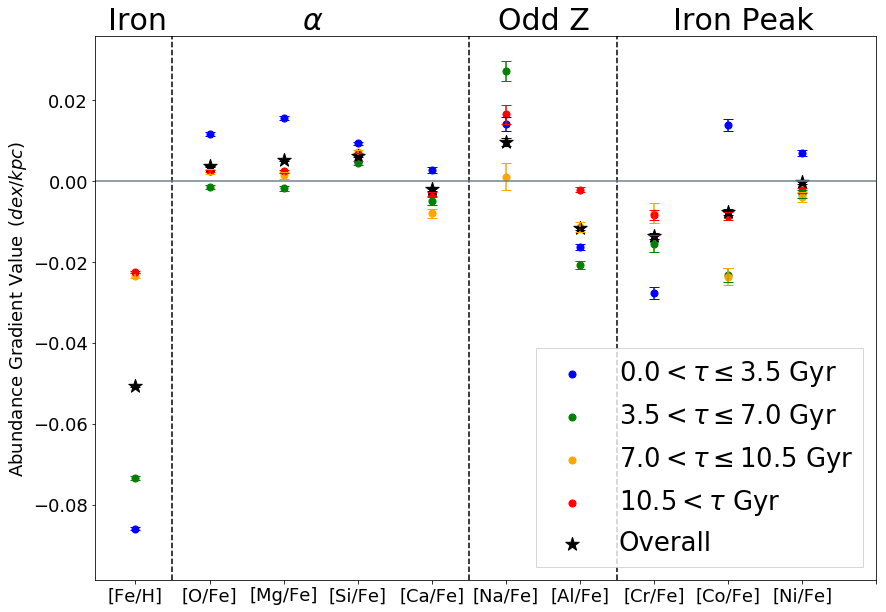

In [67]:
### Summary plot ###

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni

good_young = []
good_ymed = []
good_omed = []
good_old = []
good_over = []
err_young = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

good_idx = [17,3,5,7,11,4,6,15,18,19] #[16,4,6,10,3,5,14,2,17,18] #[2,3,4,5,6,10,14,16,17,18]
for i in good_idx:
    good_young.append(young_elems_slope[i])
    good_ymed.append(ymed_elems_slope[i])
    good_omed.append(omed_elems_slope[i])
    good_old.append(old_elems_slope[i])
    good_over.append(elems_slope[i])
    
    err_young.append(young_m_devs[i])
    err_ymed.append(ymed_m_devs[i])
    err_omed.append(omed_m_devs[i])
    err_old.append(old_m_devs[i])
    err_over.append(m_devs[i])

fig = plt.figure(figsize=[14,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_young,c='blue',label='$0.0 < \\tau \leq 3.5$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_young,yerr=err_young,c='blue',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$3.5 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_omed,yerr=err_omed,c='orange',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_old,yerr=err_old,c='red',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0375,'Iron',fontsize=30)
plt.text(2.25,0.0375,'$\\alpha$',fontsize=30)
plt.text(4.9,0.0375,'Odd Z',fontsize=30)
plt.text(7.25,0.0375,'Iron Peak',fontsize=30)

# plt.title(r'Scale Length as $h_{R}$ = 1.68 kpc')

plt.legend(loc='lower right',frameon=True,fancybox=False,fontsize='x-large')
plt.savefig('grad_summary_errs_plot.pdf',bbox_inches='tight')
plt.show()

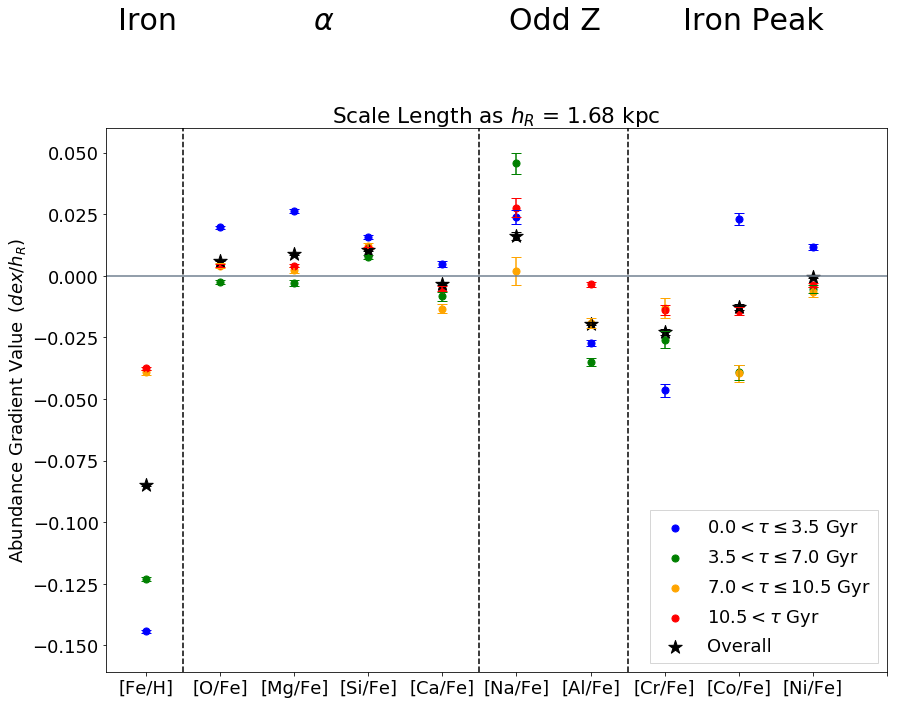

In [51]:
###########################
### Scaled Summary plot ###
###

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni

scgood_young = []
scgood_ymed = []
scgood_omed = []
scgood_old = []
scgood_over = []
scerr_young = []
scerr_ymed = []
scerr_omed = []
scerr_old = []
scerr_over = []

good_idx = [17,3,5,7,11,4,6,15,18,19] #[16,4,6,10,3,5,14,2,17,18] #[2,3,4,5,6,10,14,16,17,18]
for i in good_idx:
    scgood_young.append(scyoung_elems_slope[i])
    scgood_ymed.append(scymed_elems_slope[i])
    scgood_omed.append(scomed_elems_slope[i])
    scgood_old.append(scold_elems_slope[i])
    scgood_over.append(scelems_slope[i])
    
    scerr_young.append(scyoung_m_devs[i])
    scerr_ymed.append(scymed_m_devs[i])
    scerr_omed.append(scomed_m_devs[i])
    scerr_old.append(scold_m_devs[i])
    scerr_over.append(scm_devs[i])

fig = plt.figure(figsize=[14,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_young,c='blue',label='$0.0 < \\tau \leq 3.5$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_young,yerr=scerr_young,c='blue',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_ymed,c='green',label='$3.5 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_ymed,yerr=scerr_ymed,c='green',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_omed,yerr=scerr_omed,c='orange',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_old,yerr=scerr_old,c='red',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/h_{R})$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.1,'Iron',fontsize=30)
plt.text(2.25,0.1,'$\\alpha$',fontsize=30)
plt.text(4.9,0.1,'Odd Z',fontsize=30)
plt.text(7.25,0.1,'Iron Peak',fontsize=30)

plt.title(r'Scale Length as $h_{R}$ = 1.68 kpc')

plt.legend(loc='lower right',frameon=True,fancybox=False)
plt.savefig('scaled_grad_summary_errs_plot.pdf',bbox_inches='tight')
plt.show()

$\Huge MW Gradients$

In [ ]:
#APOGEE MW (starhorse VAC)
horse = fits.getdata('/Users/joshpovick/desktop/research/LMC_Gradients/apogee_starhorse-DR16.fits',1)
# clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
#                 (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))


apodr16 = fits.getdata('/Users/joshpovick/desktop/research/LMC_Gradients/allStar-r12-l33.fits',1) 
cln = np.where(apodr16['GAIA_R_EST']!=-9999.0) 

comb, horse_ind, apodr16_ind = np.intersect1d(horse['APOGEE_ID'], 
                                              apodr16['APOGEE_ID'][cln],return_indices=True)
matdr16 = apodr16[cln][apodr16_ind]

In [ ]:
### Calculate the Galactic Circular Radius for MW ###
import astropy.units as u
import astropy.coordinates as coord

pos = coord.ICRS(ra=matdr16['RA']*u.degree,dec=matdr16['DEC']*u.degree,
                 distance=np.reciprocal((matdr16['GAIA_R_EST']/10**3))*u.kpc)
galmwpos = pos.transform_to(coord.Galactocentric)

galmwrad = []
for i in range(len(pos)):
    xpo = (galmwpos[i].x).value
    ypo = (galmwpos[i].y).value
    galmwrad.append(np.sqrt(xpo**2+ypo**2))
    
galmwrad = np.asarray(galmwrad)

### Select stars with radius 4 to 12 kpc and less than 1 kpc in z ###
selstars = np.where((galmwrad>=4.0)&(galmwrad<=12.0)&((galmwpos.z).value<=1.0))

In [ ]:
len(np.squeeze(selstars))

In [37]:
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

### A matrix in Ax=b
# A = np.vstack([r13['LMCRAD']*0.875,np.ones(len(r13['LMCRAD']))]).T

mwelems_slope = []
mwelems_inter = []

for i in range(len(elems)-5):
    cln = np.where((matdr16[selstars][elems[i]]>-100)&(matdr16[selstars]['SNR']>=100)&
                   (kthbitset(matdr16[selstars]['ASPCAPFLAG'],23)=='False'))
    A = np.vstack([galmwrad[selstars][cln]/3.0,np.ones(len(galmwrad[selstars][cln]))]).T
    mi, ci = np.linalg.lstsq(A, matdr16[selstars][elems[i]][cln])[0]
    mwelems_slope.append(mi)
    mwelems_inter.append(ci)
    
for j in range(len(elems)-5):
    print(elems[j]+' slope: '+str(mwelems_slope[j])+ ' inter: '+ str(mwelems_inter[j]))

M_H slope: 0.07153443277733966 inter: -0.41746211041715287
C_FE slope: -0.050408260251917185 inter: 0.1691272730565198
N_FE slope: -0.09493189412320824 inter: 0.4436863098603382
O_FE slope: -0.12062690478458124 inter: 0.44014374587805355
NA_FE slope: -0.03482830432312245 inter: 0.09401099729823302
MG_FE slope: -0.1077893422856142 inter: 0.40154666759958574
AL_FE slope: -0.04080092671281493 inter: 0.16802606717364602
SI_FE slope: -0.08004201597801515 inter: 0.28504505033431293
P_FE slope: -0.10923091893033783 inter: 0.3574111779106937
S_FE slope: -0.10875722700117087 inter: 0.399157950533924
K_FE slope: -0.06431149167814387 inter: 0.26341386419860086
CA_FE slope: -0.032204481620787984 inter: 0.1409740813745122
TI_FE slope: -0.05673199119829746 inter: 0.19962875986791181
TIII_FE slope: -0.062278621010905505 inter: 0.29677327586996394
V_FE slope: -0.04647020590493664 inter: 0.1827812619456631
CR_FE slope: 0.019590557356046007 inter: -0.07690809216877326
MN_FE slope: 0.0011525269690216495 

In [38]:
# scelems_m_devs = []
# scelems_b_devs = []

# mwAdevs = []
# mwelems_values = []
# mwelems_errors = []
# for i in range(len(elems)-5):
#     cln = np.where((matdr16[selstars][elems[i]]>-100)&(matdr16[selstars]['SNR']>=100)&
#                    (kthbitset(matdr16[selstars]['ASPCAPFLAG'],23)=='False'))
#     mwAdevs.append(np.vstack([galmwrad[selstars][cln]/3.0,np.ones(len(galmwrad[selstars][cln]))]).T)
#     mwelems_values.append(matdr16[elems[i]][selstars][cln])
#     mwelems_errors.append(matdr16[elems[i]+str('_ERR')][selstars][cln])

# mwnoisy_values = []
# mwm_devs = []
# mwb_devs = []
# for j in range(len(elems)-5):
#     mwslopes = []
#     mwinters = []
#     for k in range(100):
#         mi, bi = np.linalg.lstsq(mwAdevs[j], noisy(mwelems_values[j],mwelems_errors[j]))[0]
#         mwslopes.append(mi)
#         mwinters.append(bi)
#     mwm_devs.append(mad(mwslopes))
#     mwb_devs.append(mad(mwinters))

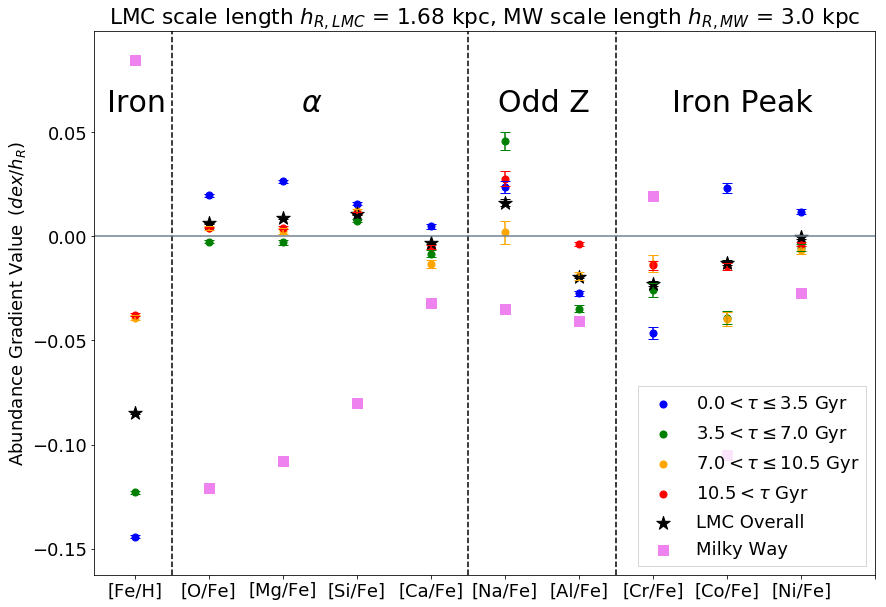

In [57]:
good_idx = [17,3,5,7,11,4,6,15,18,19] #[16,4,6,10,3,5,14,2,17,18] #[2,3,4,5,6,10,14,16,17,18]

scgood_mw = []
scgood_young = []
scgood_ymed = []
scgood_omed = []
scgood_old = []
scgood_over = []
scerr_young = []
scerr_ymed = []
scerr_omed = []
scerr_old = []
scerr_over = []
scerr_mw = []

for i in good_idx:
    scgood_young.append(scyoung_elems_slope[i])
    scgood_ymed.append(scymed_elems_slope[i])
    scgood_omed.append(scomed_elems_slope[i])
    scgood_old.append(scold_elems_slope[i])
    scgood_over.append(scelems_slope[i])
    scgood_mw.append(mwelems_slope[i])
    
    scerr_young.append(scyoung_m_devs[i])
    scerr_ymed.append(scymed_m_devs[i])
    scerr_omed.append(scomed_m_devs[i])
    scerr_old.append(scold_m_devs[i])
    scerr_over.append(scm_devs[i])
    scerr_mw.append(mwm_devs[i])

fig = plt.figure(figsize=[14,10])

plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_young,c='blue',label='$0.0 < \\tau \leq 3.5$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_young,yerr=scerr_young,c='blue',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_ymed,c='green',label='$3.5 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_ymed,yerr=scerr_ymed,c='green',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_omed,yerr=scerr_omed,c='orange',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_old,yerr=scerr_old,c='red',capsize=5.0,ls='none')
plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_mw,marker='s',c='violet',label='Milky Way',s=100)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_mw,scerr_mw,c='violet',capsize=5.0,ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']
xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/h_{R})$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.06,'Iron',fontsize=30)
plt.text(2.25,0.06,'$\\alpha$',fontsize=30)
plt.text(4.9,0.06,'Odd Z',fontsize=30)
plt.text(7.25,0.06,'Iron Peak',fontsize=30)

plt.title(r'LMC scale length $h_{R,LMC}$ = 1.68 kpc, MW scale length $h_{R,MW}$ = 3.0 kpc')

plt.legend(loc='lower right',frameon=True,fancybox=False)
plt.savefig('mw_scaled_grad_summary_errs_plot.pdf',bbox_inches='tight')
plt.show()

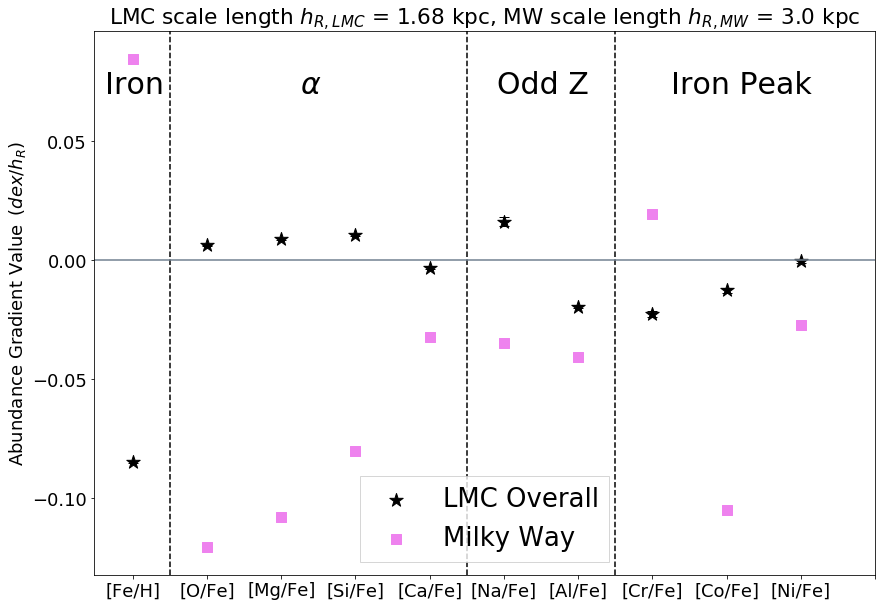

In [66]:
# good_idx = [17,3,5,7,11,4,6,15,18,19] #[16,4,6,10,3,5,14,2,17,18] #[2,3,4,5,6,10,14,16,17,18]

# scgood_mw = []
# scgood_young = []
# scgood_ymed = []
# scgood_omed = []
# scgood_old = []
# scgood_over = []
# scerr_young = []
# scerr_ymed = []
# scerr_omed = []
# scerr_old = []
# scerr_over = []
# scerr_mw = []

# for i in good_idx:
#     scgood_young.append(scyoung_elems_slope[i])
#     scgood_ymed.append(scymed_elems_slope[i])
#     scgood_omed.append(scomed_elems_slope[i])
#     scgood_old.append(scold_elems_slope[i])
#     scgood_over.append(scelems_slope[i])
#     scgood_mw.append(mwelems_slope[i])
    
#     scerr_young.append(scyoung_m_devs[i])
#     scerr_ymed.append(scymed_m_devs[i])
#     scerr_omed.append(scomed_m_devs[i])
#     scerr_old.append(scold_m_devs[i])
#     scerr_over.append(scm_devs[i])
#     scerr_mw.append(mwm_devs[i])

# fig = plt.figure(figsize=[14,10])

# plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_over,marker='*',c='black',label='LMC Overall',s=200)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_over,yerr=scerr_over,c='black',capsize=5.0,ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],scgood_mw,marker='s',c='violet',label='Milky Way',s=100)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],scgood_mw,scerr_mw,c='violet',capsize=5.0,ls='none')

# xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
#             '[Ni/Fe]']
# xplotpos = [0,1,2,3,4,5,6,7,8,9,10] 
# plt.xticks(xplotpos,xplotlab)

# plt.axvline(0.5,c='k',ls='--')
# plt.axvline(4.5,c='k',ls='--')
# plt.axvline(6.5,c='k',ls='--')
# plt.axhline(0.0,c='slategrey',ls='-')
# plt.ylabel('Abundance Gradient Value $\,(dex/h_{R})$')

# # plt.gca().set_ylim(top=0.05)

# plt.text(-0.375,0.07,'Iron',fontsize=30)
# plt.text(2.25,0.07,'$\\alpha$',fontsize=30)
# plt.text(4.9,0.07,'Odd Z',fontsize=30)
# plt.text(7.25,0.07,'Iron Peak',fontsize=30)

# plt.title(r'LMC scale length $h_{R,LMC}$ = 1.68 kpc, MW scale length $h_{R,MW}$ = 3.0 kpc')

# plt.legend(loc='lower center',frameon=True,fancybox=False,fontsize='x-large')
# plt.savefig('mwanLMConly.pdf',bbox_inches='tight')
# plt.show()

In [41]:
# unmw_slope = []
# unmw_inter = []

# for i in range(len(elems)-5):
#     cln = np.where((matdr16[selstars][elems[i]]>-100)&(matdr16[selstars]['SNR']>=100)&
#                    (kthbitset(matdr16[selstars]['ASPCAPFLAG'],23)=='False'))
#     unA = np.vstack([galmwrad[selstars][cln],np.ones(len(galmwrad[selstars][cln]))]).T
#     mi, ci = np.linalg.lstsq(unA, matdr16[selstars][elems[i]][cln])[0]
#     unmw_slope.append(mi)
#     unmw_inter.append(ci)




In [ ]:
# from scipy.stats import binned_statistic_2d

# matplotlib.rcParams.update({'font.size': 18})
# for i in range(len(elems)-5):
#     xval = np.linspace(4.0,12.0)
#     def trendline(x):
#         return unmw_slope[i]*x+unmw_inter[i]
#     cln = np.where((matdr16[selstars][elems[i]]>-100)&(matdr16[selstars]['SNR']>=100)&
#                    (kthbitset(matdr16[selstars]['ASPCAPFLAG'],23)=='False'))
#     plt.figure(figsize=[12,10])
    
#     density = binned_statistic_2d(galmwrad[selstars][cln],matdr16[selstars][elems[i]][cln],None,'count',bins=300)
#     plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                      density.y_edge[0],density.y_edge[-1]],
#                aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')
# #     plt.scatter(galmwrad[selstars][cln],matdr16[selstars][elems[i]][cln],marker='+',
# #                 c='k',label='_nolegend_')
#     plt.plot(xval,trendline(xval),c='r',lw=3.0,label='Trend: {:>5.3f}$ \,dex/kpc$'.format(unmw_slope[i]))
#     plt.legend(loc='lower right')
#     plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labs[i]))
#     plt.ylabel(r'{}'.format(labs[i]))
#     plt.xlabel(r'MW Galactic Circular Radius (kpc)')
# #     ax0 = fig.add_subplot(111)
# #     at1 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
# #     at1.patch.set_boxstyle("square")
# #     ax0.add_artist(at1)
#     plt.savefig('MWrad{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()

In [44]:
# clnalp = np.where((matdr16[selstars]['ALPHA_M']>=-100)&(matdr16[selstars]['FE_H']>=-100))
# A = np.vstack([matdr16[selstars][clnalp]['FE_H'],np.ones(len(matdr16[selstars][clnalp]['FE_H']))]).T
# m, b = np.linalg.lstsq(A, matdr16[selstars][clnalp]['ALPHA_M'])[0]
# print(m)
# print(b)

# alphstars = matdr16[selstars][clnalp]

-0.16119885604431136
0.028160372474993145


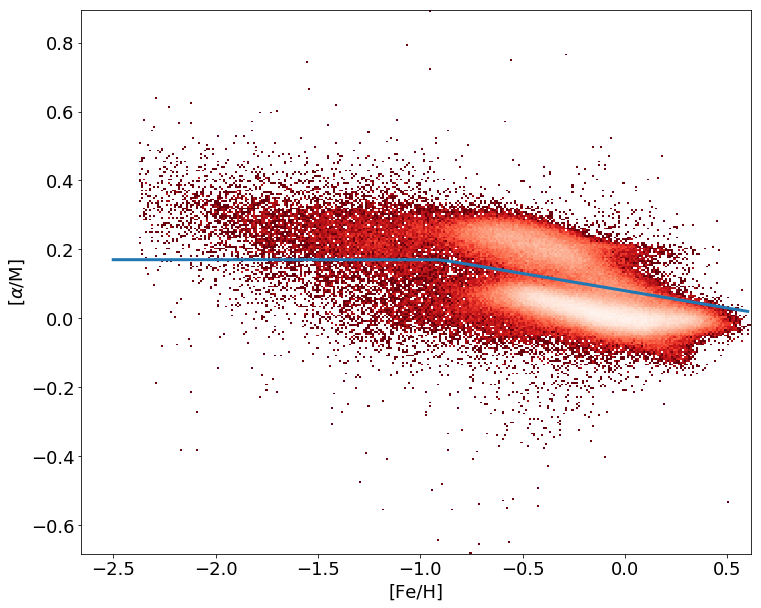

In [45]:
# plt.figure(figsize=[12,10])
# xval = np.linspace(-2.5,0.6)
# def alptrendline(x):
#     #return -0.16119885604431136*x+0.028160372474993145
#     x = np.asarray(x)
#     y = np.zeros(x.shape)
#     y += (x<=-0.9)*(-0.1*(-0.9)+0.08)
#     y += (x>-0.9)*(-0.1*x+0.08)
#     return y
 
# clnalp = np.where((matdr16[selstars]['ALPHA_M']>=-100)&(matdr16[selstars]['FE_H']>=-100))
# density = binned_statistic_2d(matdr16[selstars][clnalp]['FE_H'],matdr16[selstars][clnalp]['ALPHA_M'],
#                               None,'count',bins=300)
# plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                  density.y_edge[0],density.y_edge[-1]],
#            aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')
# plt.plot(xval,alptrendline(xval),lw=3.0)
# plt.xlabel(r'[Fe/H]')
# plt.ylabel(r'[$\alpha$/M]')
# plt.savefig('alphaplot.pdf',bbox_inches='tight')
# plt.show()
# # plt.scatter(matdr16[selstars][clnalp]['ALPHA_M'],matdr16[selstars][clnalp]['FE_H'])
# # plt.ylim(-2.5,1.0)

In [ ]:
# thin_thick = []
# for i in range(len(alphstars['ALPHA_M'])):
#     if alphstars['FE_H'][i] <= -0.9:
#         if alphstars['ALPHA_M'][i] < (-0.1*(-0.9)+0.08):
#             thin_thick.append(0.0)
#         else:
#             thin_thick.append(1.0)
#     elif alphstars['FE_H'][i] > -0.9:
#         if (-0.1*(alphstars['FE_H'][i])+0.08 > alphstars['ALPHA_M'][i]):
#             thin_thick.append(0.0)
#         else:
#             thin_thick.append(1.0)

In [ ]:
# thin = np.where(np.asarray(thin_thick)==0.0)

# plt.figure(figsize=[12,10])
# xval = np.linspace(-2.5,0.6)
# def alptrendline(x):
#     #return -0.16119885604431136*x+0.028160372474993145
#     x = np.asarray(x)
#     y = np.zeros(x.shape)
#     y += (x<=-0.9)*(-0.1*(-0.9)+0.08)
#     y += (x>-0.9)*(-0.1*x+0.08)
#     return y
 
# # clnalp = np.where((matdr16[selstars]['ALPHA_M']>=-100)&(matdr16[selstars]['FE_H']>=-100))
# density = binned_statistic_2d(alphstars['FE_H'],alphstars['ALPHA_M'],
#                               None,'count',bins=300)
# plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                  density.y_edge[0],density.y_edge[-1]],
#            aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')
# plt.plot(xval,alptrendline(xval),lw=3.0)
# plt.scatter(alphstars[thin]['FE_H'],alphstars[thin]['ALPHA_M'],c='green')
# plt.xlabel(r'[Fe/H]')
# plt.ylabel(r'[$\alpha$/M]')
# # plt.savefig('alphaplot.pdf',bbox_inches='tight')
# plt.show()

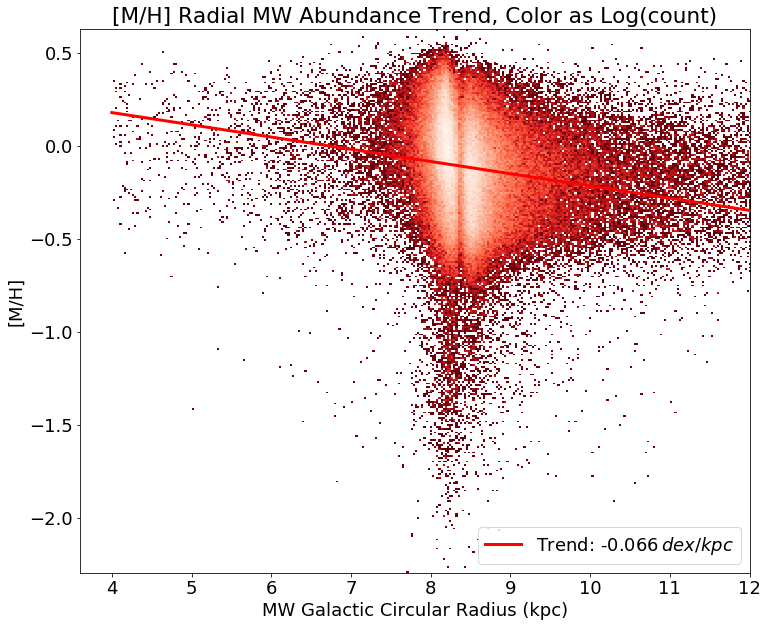

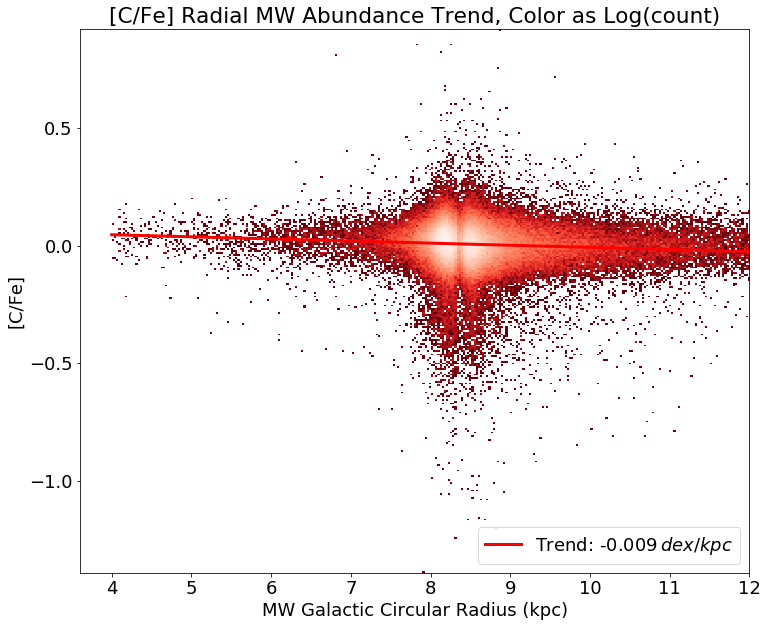

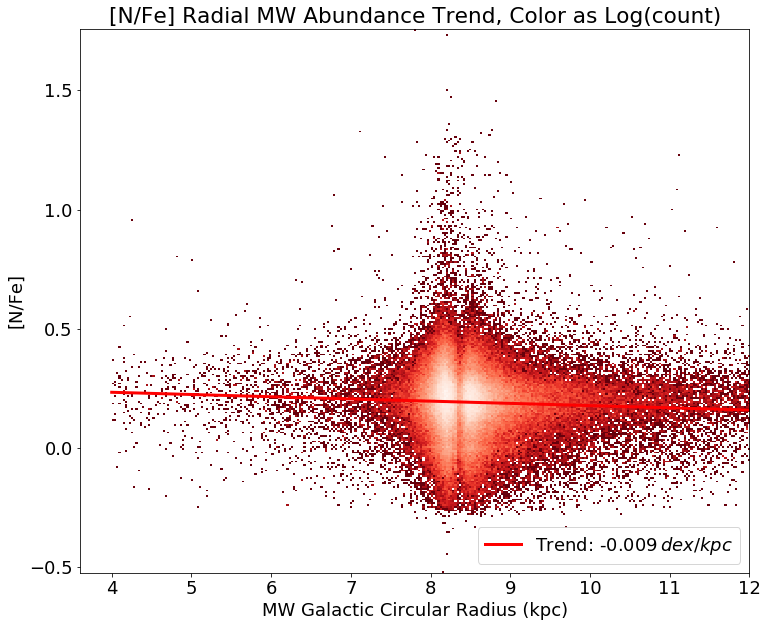

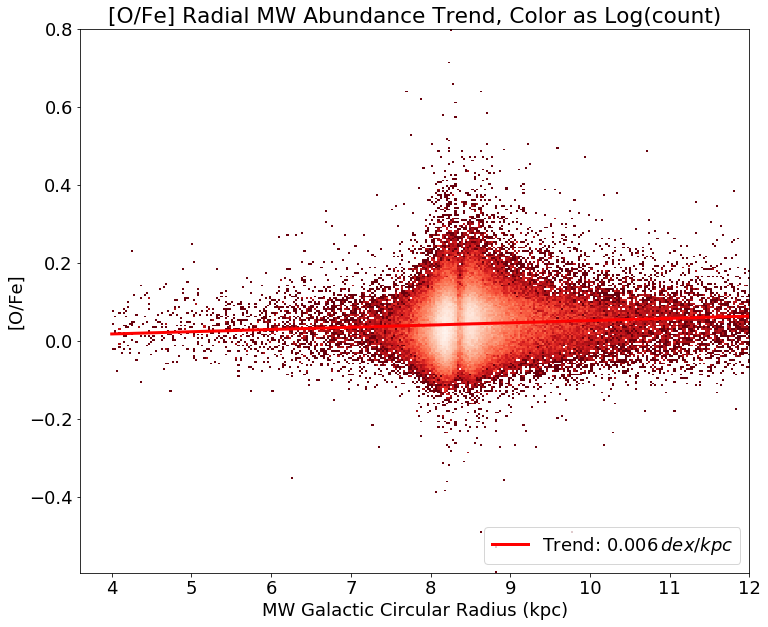

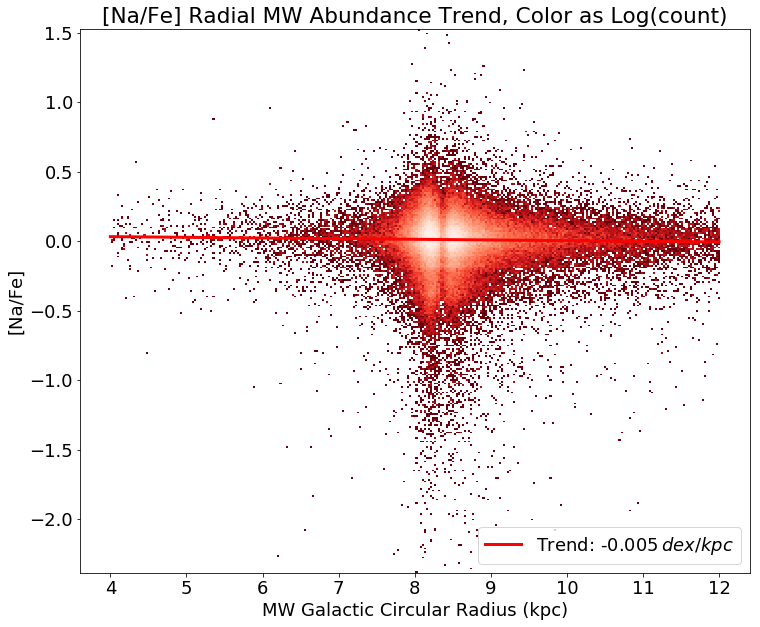

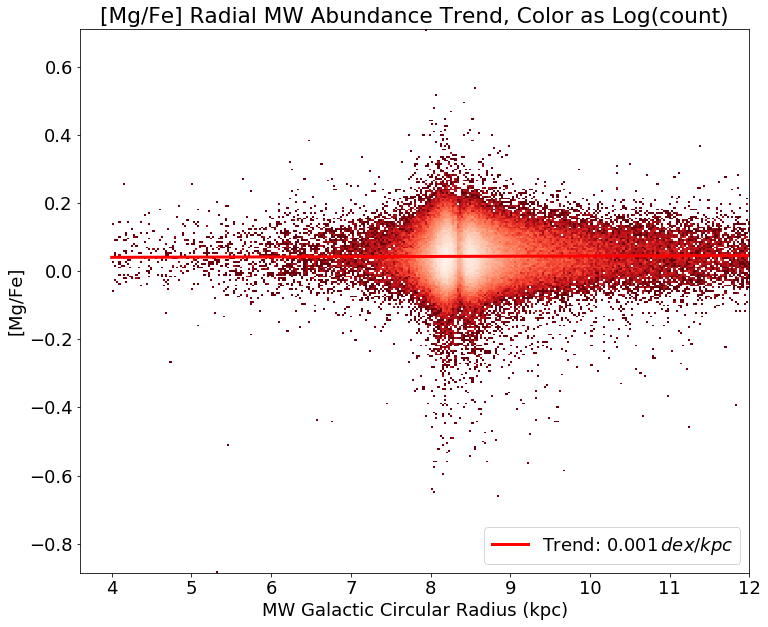

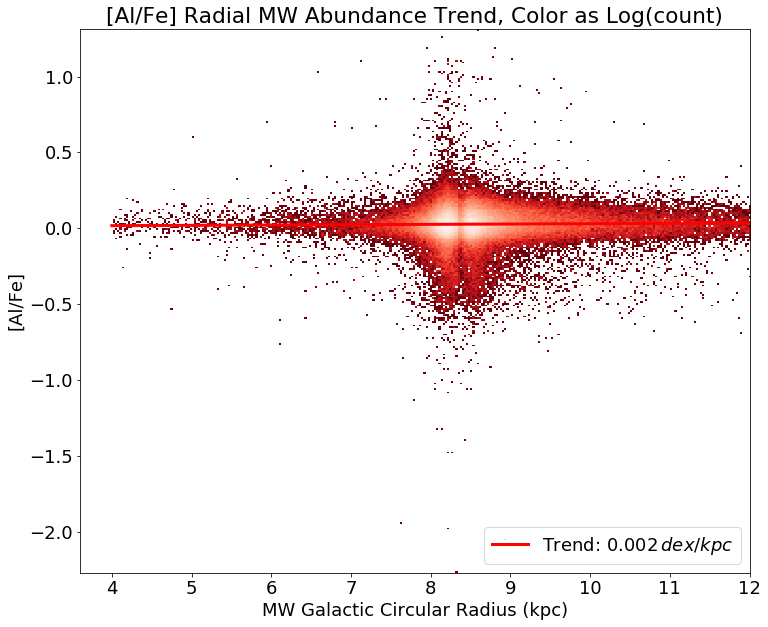

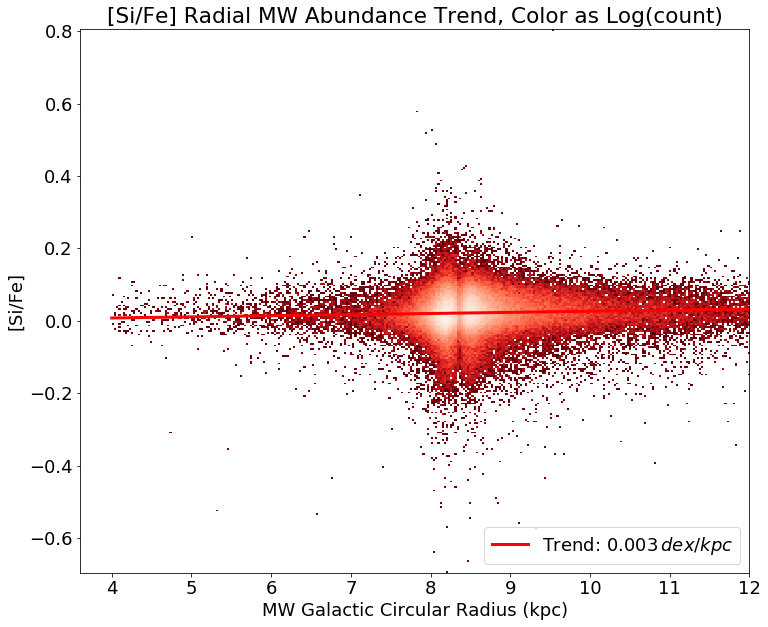

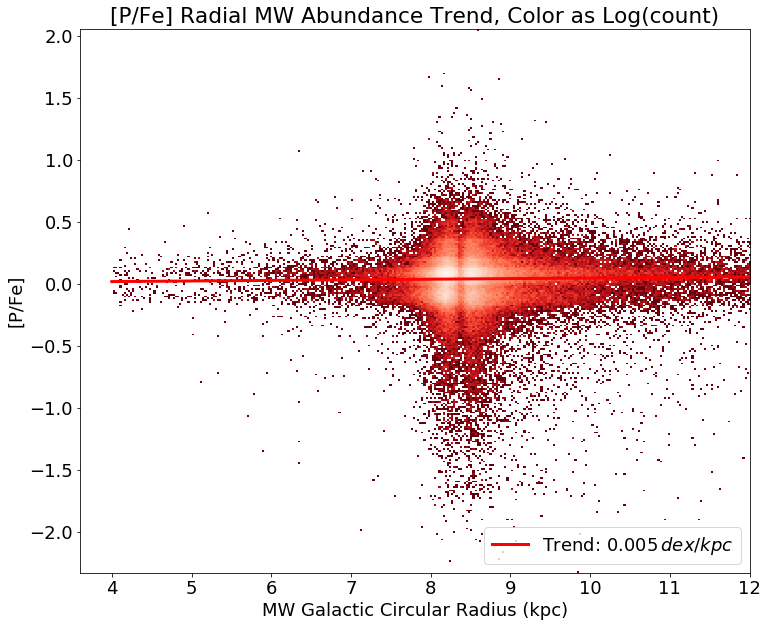

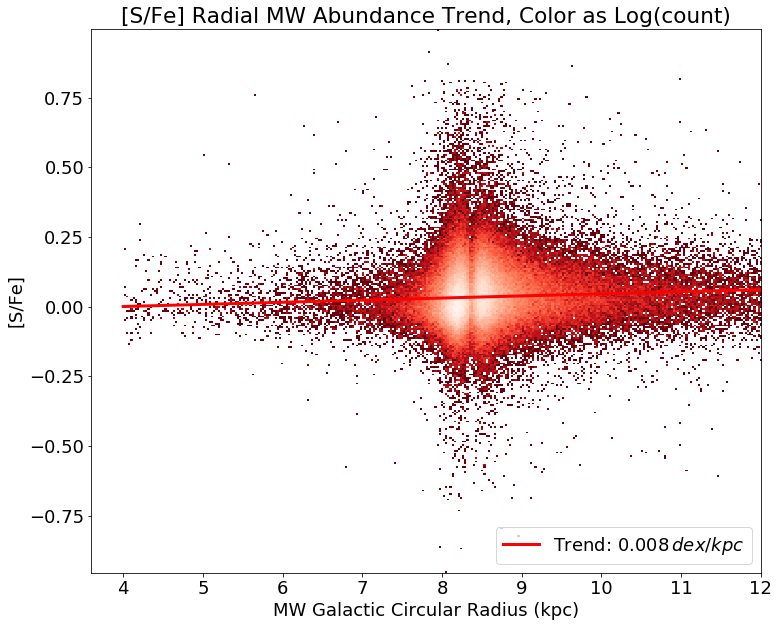

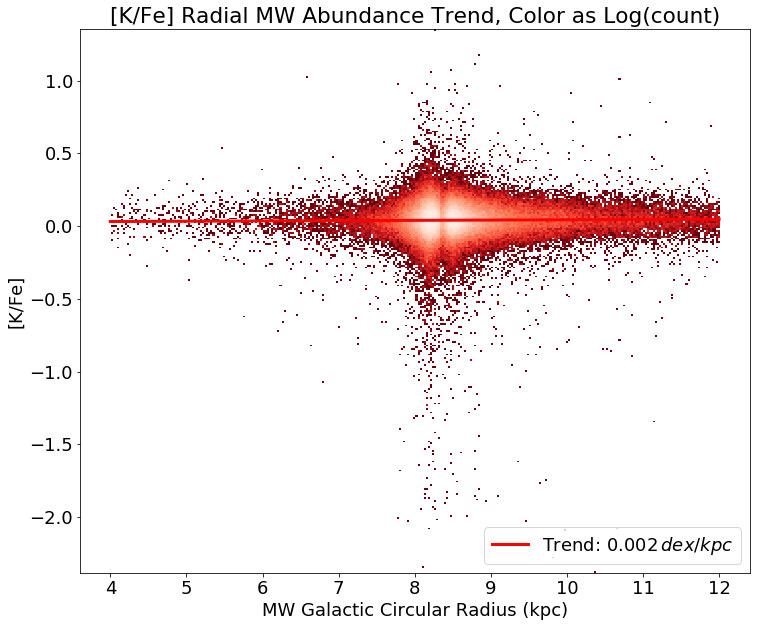

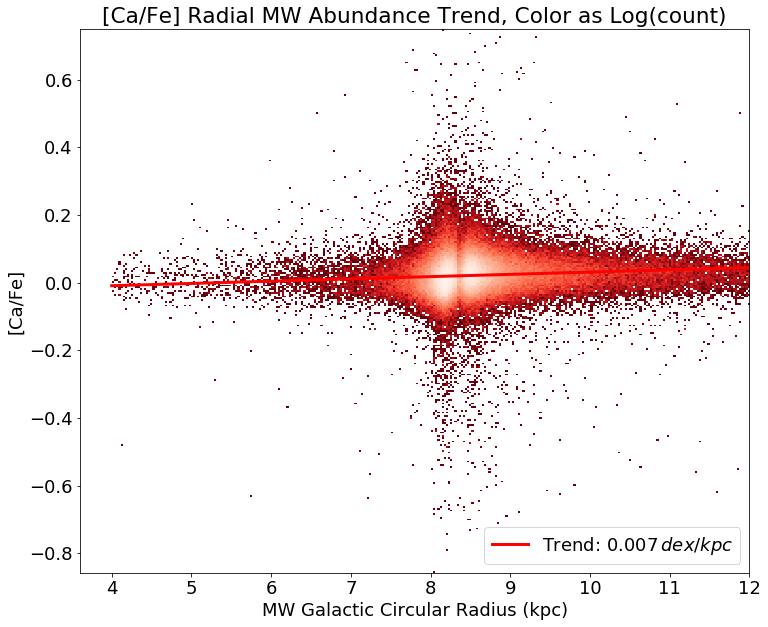

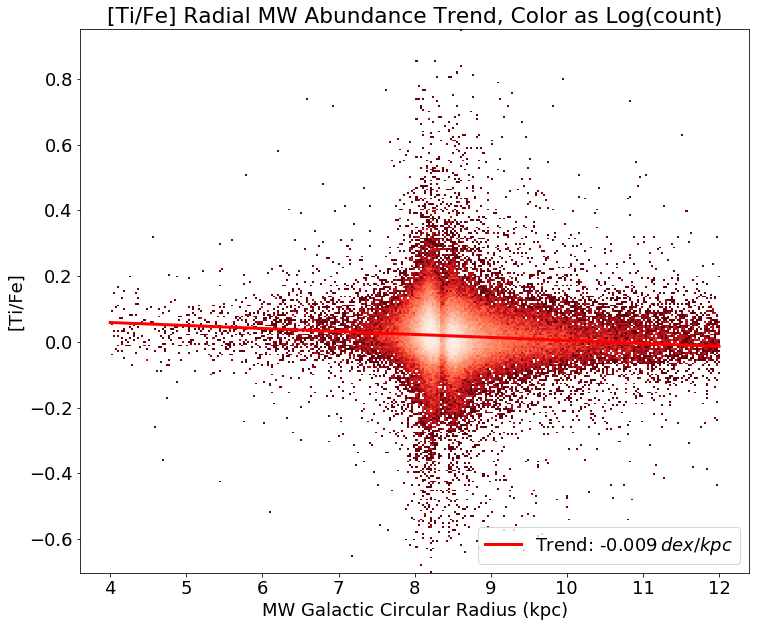

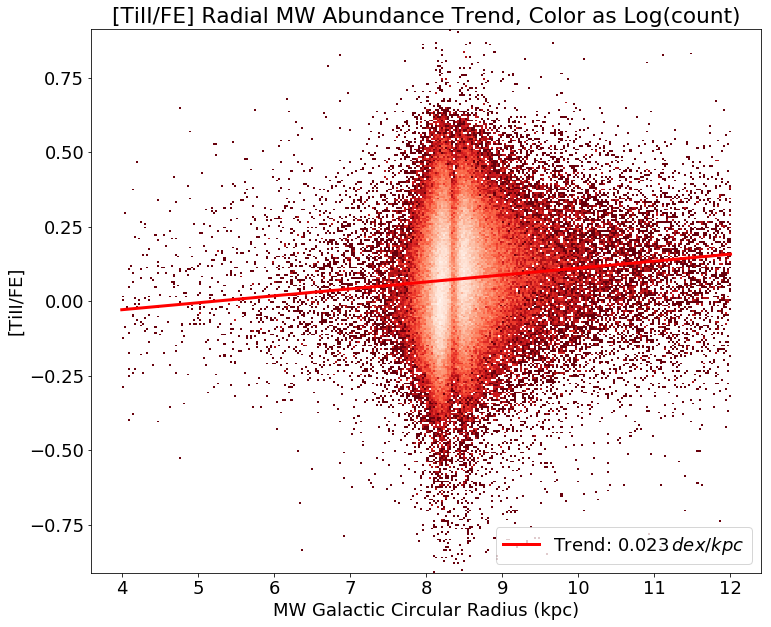

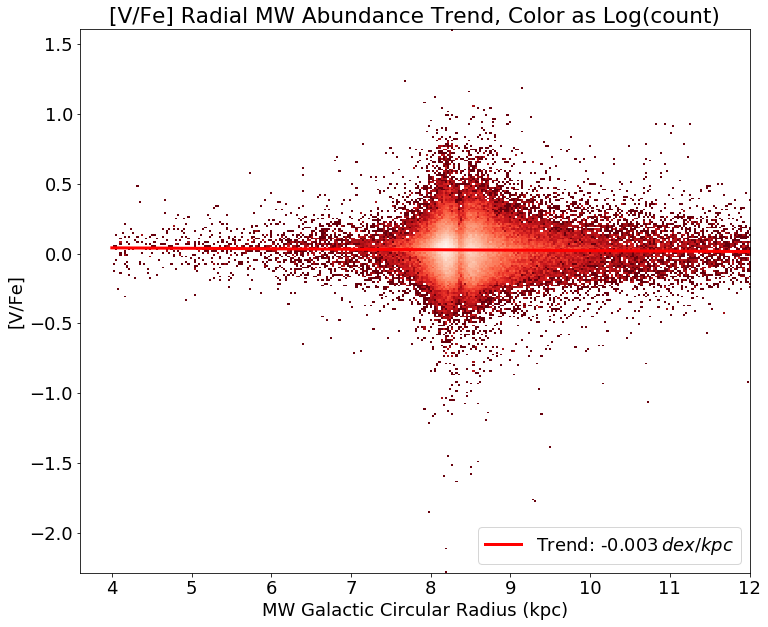

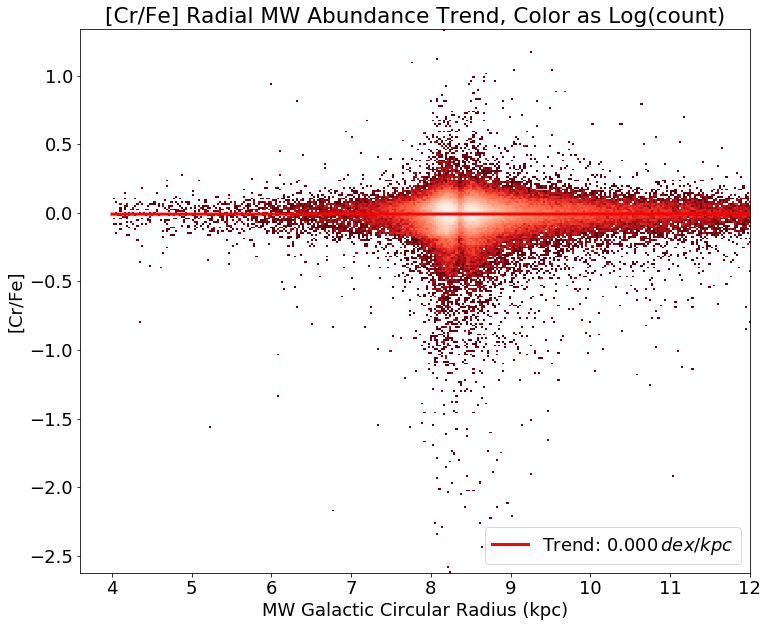

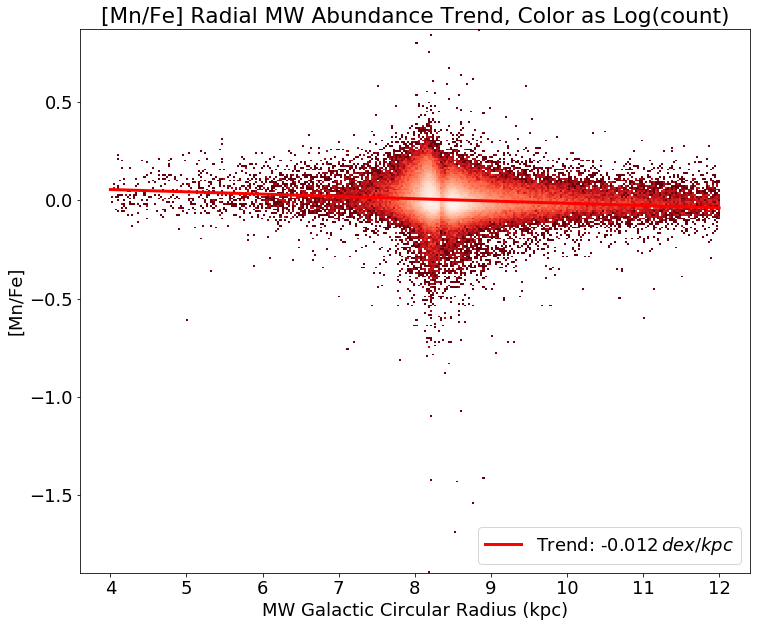

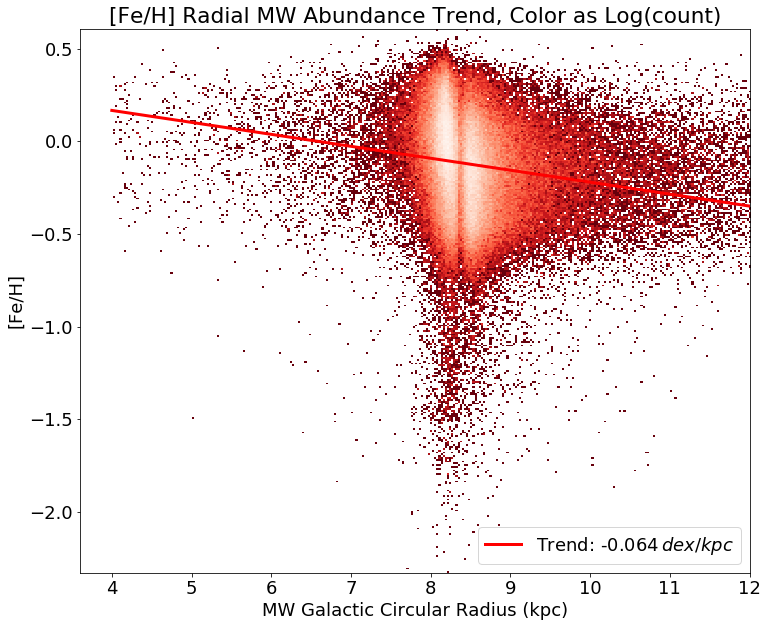

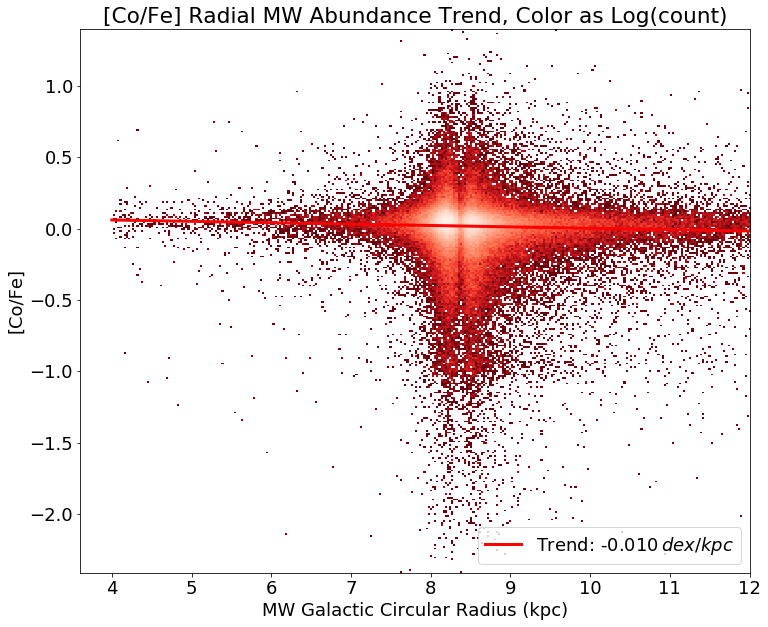

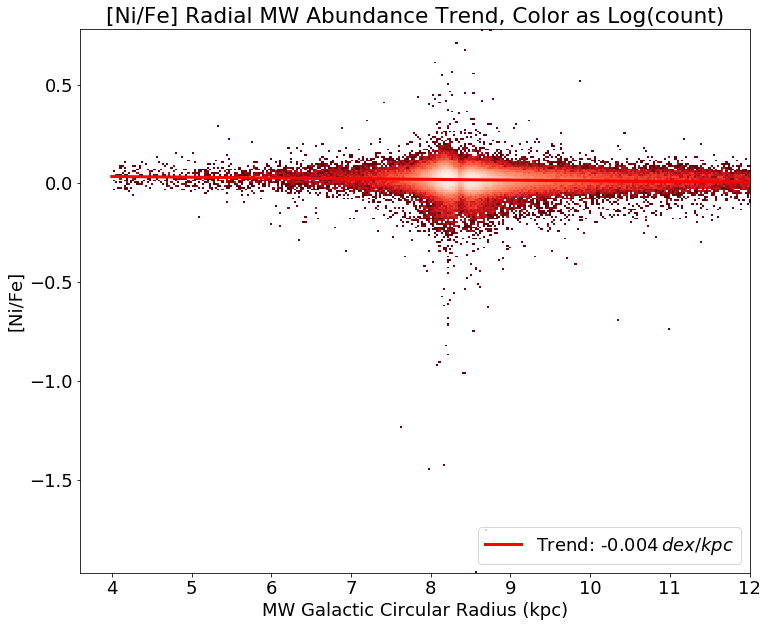

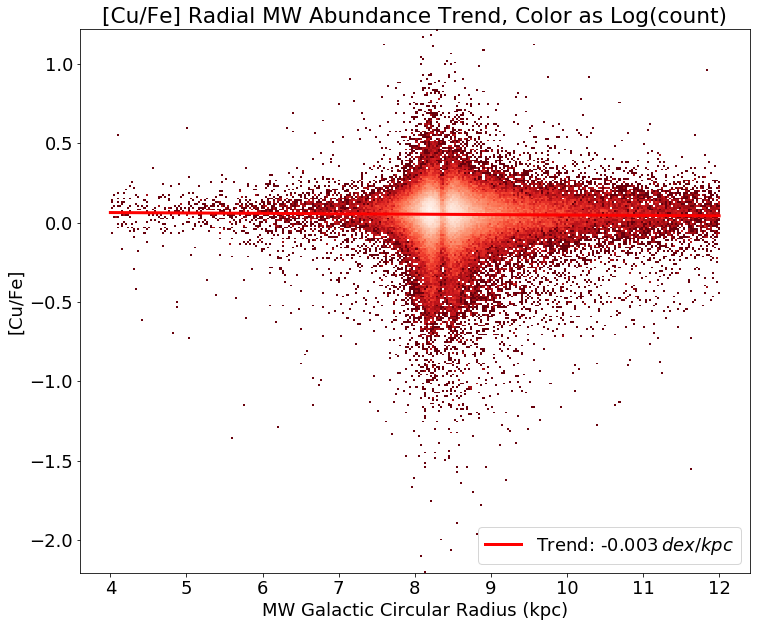

In [48]:
# from scipy.stats import binned_statistic_2d
# import statsmodels.api as sm 

# matplotlib.rcParams.update({'font.size': 18})

# mw_grads = []
# for i in range(len(elems)-5):
#     xval = np.linspace(4.0,12.0)
    
#     #Calculate the Gradient
#     cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
#     pmodl = np.array(galmwrad[selstars][thin][cln]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.RLM(alphstars[thin][elems[i]][cln],pmodl).fit()
    
#     mw_grads.append(model.params[1])
    
#     def trendline(x):
#         return model.params[1]*x+model.params[0]
    
#     plt.figure(figsize=[12,10])
    
#     density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[i]][cln],None,'count',bins=300)
#     plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                      density.y_edge[0],density.y_edge[-1]],
#                aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')

#     plt.plot(xval,trendline(xval),c='r',lw=3.0,label='Trend: {:>5.3f}$ \,dex/kpc$'.format(model.params[1]))
#     plt.legend(loc='lower right')
#     plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labs[i]))
#     plt.ylabel(r'{}'.format(labs[i]))
#     plt.xlabel(r'MW Galactic Circular Radius (kpc)')
#     plt.savefig('MWrad{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()

In [49]:
# mw_grads

[-0.06576158306758996,
 -0.008969868478884247,
 -0.00930177885349823,
 0.005723331869984012,
 -0.004766753137085558,
 0.0006458092428406399,
 0.0021531095691881413,
 0.0031046885886314166,
 0.004753938280697319,
 0.00762084105592656,
 0.002022164910468802,
 0.006708222183872423,
 -0.00909108883565344,
 0.023330946097835467,
 -0.003326207246492142,
 0.00019914289209294262,
 -0.011679243933532826,
 -0.06449599261561041,
 -0.009673474255293558,
 -0.003681398303255321,
 -0.0025822375494814792]

In [ ]:
# from scipy.stats import binned_statistic_2d
# import statsmodels.api as sm 

# matplotlib.rcParams.update({'font.size': 18})

# #### DON'T USE M/H or Fe/H FROM THIS

# labsH = ['[M/H]','[C/H]','[N/H]','[O/H]','[Na/H]','[Mg/H]','[Al/H]','[Si/H]','[P/H]','[S/H]','[K/H]',
#         '[Ca/H]','[Ti/H]','[TiII/H]','[V/H]','[Cr/H]','[Mn/H]','[Fe/H]','[Co/H]','[Ni/H]','[Cu/H]',
#         '[Ge/H]','[Rb/H]','[Ce/H]','[Nd/H]','[Yb/H]']

# mw_grads = []
# for i in range(len(elems)-5):
#     xval = np.linspace(4.0,12.0)
    
#     #Calculate the Gradient
#     cln = np.where((alphstars[thin][elems[i]]>-100)&(alphstars[thin]['SNR']>=100))
#     pmodl = np.array(galmwrad[selstars][thin][cln]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(alphstars[thin][elems[i]][cln]+alphstars[thin]['FE_H'][cln],pmodl).fit()
    
#     mw_grads.append(model.params[1])
    
#     def trendline(x):
#         return model.params[1]*x+model.params[0]
    
#     plt.figure(figsize=[12,10])
    
#     density = binned_statistic_2d(galmwrad[selstars][thin][cln],alphstars[thin][elems[i]][cln]+alphstars[thin]['FE_H'][cln],None,'count',bins=300)
#     plt.imshow(np.log10(density.statistic.T), origin='lower',extent=[density.x_edge[0],density.x_edge[-1],
#                                                                      density.y_edge[0],density.y_edge[-1]],
#                aspect='auto', interpolation='nearest',cmap='Reds_r',label='_nolegend_')

#     plt.plot(xval,trendline(xval),c='r',lw=3.0,label='Trend: {:>5.3f}$ \,dex/kpc$'.format(model.params[1]))
#     plt.legend(loc='lower right')
#     plt.title(r'{} Radial MW Abundance Trend, Color as Log(count)'.format(labsH[i]))
#     plt.ylabel(r'{}'.format(labsH[i]))
#     plt.xlabel(r'MW Galactic Circular Radius (kpc)')
#     plt.savefig('MWradH{}.pdf'.format(els[i]),bbox_inches='tight')
#     plt.show()

In [72]:
# matdr16.columns

ColDefs(
    name = 'APSTAR_ID'; format = '57A'
    name = 'TARGET_ID'; format = '47A'
    name = 'ASPCAP_ID'; format = '59A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na